### make_pitstop_dataset-nextpit

base: 16./make_gluonts_dataset-pitagemodel

build a pitstop dataset with <cautions_laps, pitage, gap2nextpit>
gluonts interface of Dataset = Iterable[DataEntry], DataEntry = Dict(str, any)

+ input pitstop dataset, remove pitstops with pit_oncaution = 1, refer to lapstatus_dataset-fastrun
+ context_length = 1, prediction_length = 1
+ target : gap to nextpit
+ covariates are: cautions_laps, pitage, (carid, eid)
+ modeling the distribution of nextpit-gap


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import random
import mxnet as mx
from mxnet import gluon
import pickle
import json
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import inspect
from scipy import stats
from sklearn.metrics import mean_squared_error
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.model.predictor import Predictor
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.distribution.student_t import StudentTOutput

from indycar.model.mlp import MLPEstimator

INFO:root:Using GPU


In [2]:
import os
os.getcwd()

'/scratch_hdd/hpda/indycar/notebook/17.StintSimulator'

In [3]:

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def test_flag(a, bitflag):
    return (a & bitflag) ==  bitflag

#
# remove NaN at the tail
# there should be no nans in the middle of the ts
COL_LAPTIME=0
COL_RANK=1
COL_TRACKSTATUS=2
COL_LAPSTATUS=3
COL_TIMEDIFF=4
COL_CAUTION_LAPS_INSTINT=5
COL_LAPS_INSTINT= 6
COL_ELAPSED_TIME= 7
COL_LAP2NEXTPIT = 8


MODE_ORACLE = 0
MODE_NOLAP = 1
MODE_NOTRACK = 2
MODE_TESTZERO = 4
MODE_TESTCURTRACK = 8
#MODE_STR={MODE_ORACLE:'oracle', MODE_NOLAP:'nolap',MODE_NOTRACK:'notrack',MODE_TEST:'test'}

def split_ts(rec, carno, eid):
    """
    input: 
        ts
    output:
        nextpit records
    """
    output = []
    pitstops = np.where(rec[COL_LAPSTATUS,:] == 1)[0]
    
    if len(pitstops)==0:
        print('no pit ts')
        return output
    
    #pit_oncaution = np.zeros_like((pitstops))
    #for pit in pitstops:
    #    if rec[COL_TRACKSTATUS,:] == 1:
    #        pit_oncaution = 1
    pit_oncaution = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    stint_len = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    pos = 0
    for pit in pitstops:
        if rec[COL_TRACKSTATUS,pit] == 1:
            #next pit is oncaution
            # set pos -> pit as oncaution
            pit_oncaution[pos:pit] = 1
        else:
            pit_oncaution[pos:pit] = 0
            
        stint_len[pos:pit] = pit - pos
        pos = pit
        
            
    #prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap, stintlen
    totallen = pitstops[-1]
    #output = np.zeros((totallen, 6 ))
    #for idx in range(totallen):
    #    output[idx, 0] = rec[COL_LAP2NEXTPIT ,idx]
    #    output[idx, 1] = rec[COL_CAUTION_LAPS_INSTINT ,idx]
    #    output[idx, 2] = rec[COL_LAPS_INSTINT ,idx]
    #    output[idx, 3] = pit_oncaution[idx]
    #    output[idx, 4] = carno
    #    output[idx, 5] = eid
        
    for idx in range(totallen):
        output.append([ rec[COL_LAP2NEXTPIT ,idx]
                        ,rec[COL_CAUTION_LAPS_INSTINT ,idx]
                        ,rec[COL_LAPS_INSTINT ,idx]
                        ,pit_oncaution[idx]
                        ,carno
                        ,eid
                        ,idx
                        ,stint_len[idx]
                      ])
        
    return output

def make_dataset_byevent(test_event = 'Indy500-2018'):
    """
    split the ts to train and test part by the ratio
    
    oracle_mode: false to simulate prediction in real by 
        set the covariates of track and lap status as nan in the testset
            
    
    """    
    useeid = False
    run_ts = COL_LAP2NEXTPIT
    train_set = []
    test_set = []
    
    #_data: eventid, carids, datalist[carnumbers, features, lapnumber]->[laptime, rank, track, lap]]
    for _data in laptime_data:
        _train = []
        _test = []
        
        if events[_data[0]] == test_event:
            test_mode = True
        else:
            test_mode = False
            
        # process for each ts
        for rowid in range(_data[2].shape[0]):
            # rec[features, lapnumber] -> [laptime, rank, track_status, lap_status,timediff]]
            rec = _data[2][rowid].copy()
            
            #remove nan(only tails)
            nans, x= nan_helper(rec[run_ts,:])
            nan_count = np.sum(nans)             
            rec = rec[:, ~np.isnan(rec[run_ts,:])]
            
            # remove short ts
            totallen = rec.shape[1]
            
            carno = _data[1][rowid]
            carid = global_carids[_data[1][rowid]]
            
            eid = _data[0]
            
            # all go to train set
            output = split_ts(rec, carno, eid)
            #if len(output) == 0:
            #    continue
            
            test_rec_cnt = 0
            if not test_mode:
                _train.extend(output)
                
            else:
                _test.extend(output)
                test_rec_cnt += 1
            
            #add one ts
            print(f'carno:{carno}, totallen:{totallen}, nancount:{nan_count}, test_reccnt:{test_rec_cnt}')

        train_set.extend(_train)
        test_set.extend(_test)

    print(f'train len:{len(train_set)}, test len:{len(test_set)}')
    
    return train_set, test_set

def save_dataset(datafile,freq, prediction_length, cardinality, train_ds, test_ds):
    with open(datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = [freq, prediction_length, cardinality, train_ds, test_ds]
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

### create dbs

In [4]:
#years = ['2013','2014','2015','2016','2017','2018','2019']
years = ['2013','2014','2015','2016','2017','2018','2019']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}
dbid = f'Indy500_{years[0]}_{years[-1]}_v9'
testevent = 'Indy500-2018'
# start from here
import pickle
#with open('laptime_rank_timediff_fulltest-oracle-%s.pickle'%year, 'rb') as f:
with open(f'laptime_rank_timediff_pit-oracle-{dbid}.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    global_carids, laptime_data = pickle.load(f, encoding='latin1') 

In [5]:
train, test =  make_dataset_byevent(test_event = 'Indy500-2018')
#prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap
df_train = pd.DataFrame(train,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                 'carno','eid','lap','stint_len'])
df_test = pd.DataFrame(test,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                 'carno','eid','lap','stint_len'])



carno:1, totallen:200, nancount:0, test_reccnt:0
carno:2, totallen:200, nancount:0, test_reccnt:0
carno:3, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:4, totallen:0, nancount:200, test_reccnt:0
carno:5, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:6, totallen:30, nancount:170, test_reccnt:0
carno:7, totallen:177, nancount:23, test_reccnt:0
carno:8, totallen:200, nancount:0, test_reccnt:0
carno:9, totallen:200, nancount:0, test_reccnt:0
carno:10, totallen:187, nancount:13, test_reccnt:0
carno:11, totallen:200, nancount:0, test_reccnt:0
carno:12, totallen:200, nancount:0, test_reccnt:0
carno:14, totallen:200, nancount:0, test_reccnt:0
carno:15, totallen:170, nancount:30, test_reccnt:0
carno:16, totallen:179, nancount:21, test_reccnt:0
carno:18, totallen:200, nancount:0, test_reccnt:0
carno:19, totallen:200, nancount:0, test_reccnt:0
carno:20, totallen:200, nancount:0, test_reccnt:0
carno:21, totallen:170, nancount:30, test_reccnt:0
carno:22, totallen:200, nancount:

In [6]:
datafile = 'pitstop_nextpit_dataset-{dbid}-t{testevent}.pickle'
with open(datafile, 'wb') as f:
    savedata = [df_train, df_test, events, testevent]
    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

In [7]:
df_train

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len
0,30.0,0.0,1.0,0.0,1,0,0,30.0
1,29.0,0.0,2.0,0.0,1,0,1,30.0
2,28.0,0.0,3.0,0.0,1,0,2,30.0
3,27.0,1.0,4.0,0.0,1,0,3,30.0
4,26.0,2.0,5.0,0.0,1,0,4,30.0
...,...,...,...,...,...,...,...,...
30279,2.0,0.0,0.0,1.0,98,6,174,2.0
30280,1.0,1.0,1.0,1.0,98,6,175,2.0
30281,2.0,0.0,0.0,1.0,98,6,176,2.0
30282,1.0,1.0,1.0,1.0,98,6,177,2.0


In [8]:
train_sel = df_train[(df_train['pit_oncaution']==0) &(df_train['stint_len']>23)]
test_sel = df_test[(df_test['pit_oncaution']==0) &(df_test['stint_len']>23)]
datafile = 'pitstop_nextpit_dataset-{dbid}-t{testevent}-sel.pickle'
with open(datafile, 'wb') as f:
    savedata = [train_sel, test_sel, events, testevent]
    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

In [9]:
print(len(train_sel), len(test_sel))

17966 3638


In [10]:
#make gluonts
from sklearn.preprocessing import StandardScaler,MinMaxScaler

def makedb(data, scaler='standard', perm = True):
    db = []
    start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
    
    scalers = {'minmax':MinMaxScaler(), 'standard':StandardScaler()}
    
    if isinstance(scaler, str):
        if scaler in scalers:
            scaler = scalers[scaler]
            scaler.fit(data)
            df = scaler.transform(data)
        else:
            # no scaler
            df = data
    else:
        #use input scaler
        scaler.fit(data)
        df = scaler.transform(data)
        
    
    #permute
    if perm:
        perm = np.random.permutation(len(df))
        df = df[perm]
    
    for x in df:
        
        #db.append({'target':np.array(x[0]), 'feat':[np.array(x[1]),np.array(x[2])]})
        db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2]]),
                  "start":start, 'forecast_start':start})
        #db.append({'target':np.array(x[0]).reshape((1,-1)), 'feat':[np.array(x[1]).reshape((1,-1)),np.array(x[2]).reshape((1,-1))]})
        
    return db, scaler


# negbin, use no sclaer
#train_ds, scaler = makedb(train_sel[['lap2nextpit','caution_laps','pitage']].values, scaler='')
#train_ds, scaler = makedb(train_sel[['lap2nextpit','caution_laps','pitage']].values, scaler='minmax')
train_ds, scaler = makedb(train_sel[['lap2nextpit','caution_laps','pitage']].values, scaler='standard')
test_ds, _ = makedb(test_sel[['lap2nextpit','caution_laps','pitage']].values, scaler, perm=False)


### train

In [11]:
def train_model(epochs, layers=[10,10,5], output = 'student', dropout = .5):
    distr_outputs ={'student':StudentTOutput(),  
                    'negbin':NegativeBinomialOutput() 
                   }
    if not output in distr_outputs:
        print(f'distr_output: {output} not found error.')
        return
    
    distr_output = distr_outputs[output]
    
    modelid = 'mlp-e%s-l%s-%s-d%s'%(epochs, '-'.join([str(x) for x in layers]), output, dropout)
    
    estimator = MLPEstimator(
        num_hidden_dimensions=layers,
        prediction_length=1,
        context_length=1,
        freq='1min',
        dropout = dropout,
        distr_output = distr_output,
        trainer=Trainer(ctx="gpu(0)", 
                        batch_size = 32,
                        epochs= epochs,
                        learning_rate=1e-3,
                        hybridize=False,
                        num_batches_per_epoch=100
                       )
    )    

    predictor = estimator.train(train_ds)

    return predictor, modelid

In [18]:
def eval_model(predictor):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset    
        predictor=predictor,  # predictor                                  
        num_samples=100,  # number of sample paths we want for evaluation 
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)     
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9]) 
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    print(json.dumps(agg_metrics, indent=4)) 
    return tss, forecasts, agg_metrics

def get_pred(tss, forecasts, idx):
    rec = np.zeros((3))
    rec[0] = list(tss[idx].values)[0]
    
    if isinstance(scaler, str):
        truth = int(rec[0])
    else:
        truth = int(scaler.inverse_transform(rec)[0])
    
    ret = []
    for sample in forecasts[idx].samples:
        rec[0] = sample
        if isinstance(scaler, str):
            ret.append(int(rec[0]))    
        else:
            ret.append(int(scaler.inverse_transform(rec)[0]))    
        
    print('idx:', idx, 't:', truth, 'p:', int(np.mean(ret)))
    plt.hist(ret, bins=range(min(ret),max(ret)+1), alpha=0.7, label='%s'%idx)
    return truth, ret

def run_test(tss, forecasts, testlist):
    for idx in testlist:
        get_pred(tss, forecasts, idx)
    plt.legend()

In [13]:
#model store
p, t, s, e = {}, {} ,{}, {}

In [259]:
pm, mid = train_model(100, output='negbin')
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 190.42it/s, avg_epoch_loss=0.274]
INFO:root:Epoch[0] Elapsed time 0.527 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.274280
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 201.89it/s, avg_epoch_loss=0.146]
INFO:root:Epoch[1] Elapsed time 0.497 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.146411
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 204.63it/s, avg_epoch_loss=-.132]
INFO:root:Epoch[2] Elapsed time 0.490 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.131661
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 202.26it/s, avg_epoch_loss=-.351]
INFO:root:Epoch[3] Elapsed time 0.496 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.350828
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 197.72

INFO:root:Epoch[36] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 216.31it/s, avg_epoch_loss=-7.01]
INFO:root:Epoch[36] Elapsed time 0.463 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-7.013602
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 214.84it/s, avg_epoch_loss=-7.22]
INFO:root:Epoch[37] Elapsed time 0.467 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-7.220162
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 213.49it/s, avg_epoch_loss=-7.26]
INFO:root:Epoch[38] Elapsed time 0.470 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-7.262187
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 214.20it/s, avg_epoch_loss=-7.69]
INFO:root:Epoch[39] Elapsed time 0.468 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-7.689768
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 199.59it/s, avg_e

INFO:root:Epoch[72] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 208.58it/s, avg_epoch_loss=-7.56]
INFO:root:Epoch[72] Elapsed time 0.481 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-7.564782
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 209.01it/s, avg_epoch_loss=-7.71]
INFO:root:Epoch[73] Elapsed time 0.480 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-7.706283
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 209.61it/s, avg_epoch_loss=-7.22]
INFO:root:Epoch[74] Elapsed time 0.478 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-7.223195
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 208.20it/s, avg_epoch_loss=-7.32]
INFO:root:Epoch[75] Elapsed time 0.482 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-7.323338
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 206.02i

{
    "MSE": 471.15785202022226,
    "abs_error": 68006.0,
    "abs_target_sum": 68152.0,
    "abs_target_mean": 18.733369983507423,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.911728086219565,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 13784.2,
    "Coverage[0.1]": 0.008246289169873557,
    "QuantileLoss[0.5]": 68006.0,
    "Coverage[0.5]": 0.019241341396371632,
    "QuantileLoss[0.9]": 120720.0,
    "Coverage[0.9]": 0.040131940626717974,
    "RMSE": 21.706170828136,
    "NRMSE": 1.1586901260822684,
    "ND": 0.9978577297804907,
    "wQuantileLoss[0.1]": 0.20225672027233244,
    "wQuantileLoss[0.5]": 0.9978577297804907,
    "wQuantileLoss[0.9]": 1.7713346636929217,
    "mean_wQuantileLoss": 0.9904830379152484,
    "MAE_Coverage": 0.4774601429356789
}


Running evaluation: 100%|██████████| 3638/3638 [00:19<00:00, 187.50it/s]


{
    "MSE": 0.5859370000639527,
    "abs_error": 2351.5673054583067,
    "abs_target_sum": 3083.21469670675,
    "abs_target_mean": 0.8475026653949286,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.5288442391065589,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 3083.2146967067506,
    "Coverage[0.1]": 0.5046728971962616,
    "QuantileLoss[0.5]": 2351.5673054583067,
    "Coverage[0.5]": 0.6437603078614623,
    "QuantileLoss[0.9]": 943.9575905878355,
    "Coverage[0.9]": 0.8554150632215503,
    "RMSE": 0.7654652180628149,
    "NRMSE": 0.9032009565493402,
    "ND": 0.7626998236516153,
    "wQuantileLoss[0.1]": 1.0000000000000002,
    "wQuantileLoss[0.5]": 0.7626998236516153,
    "wQuantileLoss[0.9]": 0.3061601878053116,
    "mean_wQuantileLoss": 0.6896200038189756,
    "MAE_Coverage": 0.19767271394539124
}
idx: 31 t: 31 p: 35
idx: 816 t: 44 p: 37
idx: 846 t: 14 p: 18
idx: 856 t: 4 p: 18


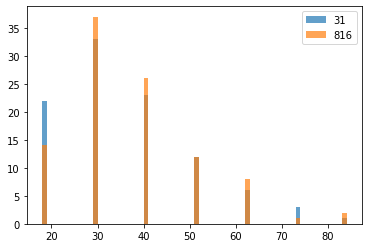

In [263]:
t[mid],s[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [14]:
pm, mid = train_model(500,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 150.99it/s, avg_epoch_loss=1.39]
INFO:root:Epoch[0] Elapsed time 0.666 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.394312
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 160.10it/s, avg_epoch_loss=0.687]
INFO:root:Epoch[1] Elapsed time 0.626 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.686772
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 131.25it/s, avg_epoch_loss=0.472]
INFO:root:Epoch[2] Elapsed time 0.764 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.471568
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 160.94it/s, avg_epoch_loss=0.449]
INFO:root:Epoch[3] Elapsed time 0.624 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.448830
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 164.28it/

100%|██████████| 100/100 [00:00<00:00, 152.22it/s, avg_epoch_loss=0.113]
INFO:root:Epoch[36] Elapsed time 0.659 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=0.112871
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 149.51it/s, avg_epoch_loss=0.129]
INFO:root:Epoch[37] Elapsed time 0.670 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.129374
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 151.53it/s, avg_epoch_loss=0.139]
INFO:root:Epoch[38] Elapsed time 0.662 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.138806
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 150.92it/s, avg_epoch_loss=0.134]
INFO:root:Epoch[39] Elapsed time 0.665 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.133618
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 140.45it/s, avg_epoch_loss=0.121]
INFO:root:Epoch[40] Elapsed time 0.

INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 155.06it/s, avg_epoch_loss=0.102]
INFO:root:Epoch[73] Elapsed time 0.646 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.102307
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 151.69it/s, avg_epoch_loss=0.126]
INFO:root:Epoch[74] Elapsed time 0.661 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.125568
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 152.60it/s, avg_epoch_loss=0.0981]
INFO:root:Epoch[75] Elapsed time 0.657 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.098130
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 151.54it/s, avg_epoch_loss=0.11]
INFO:root:Epoch[76] Elapsed time 0.662 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.109842
INFO:root:Loading parameters from best epoch (66)
INFO:root:Epoch[77] Learning rate is 0.0005
100%|█████████

100%|██████████| 100/100 [00:00<00:00, 155.74it/s, avg_epoch_loss=0.118]
INFO:root:Epoch[108] Elapsed time 0.644 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=0.117594
INFO:root:Epoch[109] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 154.14it/s, avg_epoch_loss=0.0997]
INFO:root:Epoch[109] Elapsed time 0.650 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.099670
INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 154.07it/s, avg_epoch_loss=0.115]
INFO:root:Epoch[110] Elapsed time 0.650 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.115173
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 153.44it/s, avg_epoch_loss=0.105]
INFO:root:Epoch[111] Elapsed time 0.653 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.105119
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 154.12it/s, avg_epoch_loss=0.082]
INFO:root:

100%|██████████| 100/100 [00:00<00:00, 160.17it/s, avg_epoch_loss=0.112]
INFO:root:Epoch[144] Elapsed time 0.626 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=0.112488
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.75it/s, avg_epoch_loss=0.112]
INFO:root:Epoch[145] Elapsed time 0.632 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.112278
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.89it/s, avg_epoch_loss=0.108]
INFO:root:Epoch[146] Elapsed time 0.627 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.108080
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.34it/s, avg_epoch_loss=0.0745]
INFO:root:Epoch[147] Elapsed time 0.622 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.074546
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.96it/s, avg_epoch_loss=0.118]
INFO:root:Epoch[148] E

100%|██████████| 100/100 [00:00<00:00, 161.34it/s, avg_epoch_loss=0.093]
INFO:root:Epoch[180] Elapsed time 0.621 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.093020
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.18it/s, avg_epoch_loss=0.12]
INFO:root:Epoch[181] Elapsed time 0.638 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.119944
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.06it/s, avg_epoch_loss=0.0908]
INFO:root:Epoch[182] Elapsed time 0.615 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.090789
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.65it/s, avg_epoch_loss=0.113]
INFO:root:Epoch[183] Elapsed time 0.620 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.112939
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.63it/s, avg_epoch_loss=0.111]
INFO:root:Epoch[184] El

100%|██████████| 100/100 [00:00<00:00, 147.69it/s, avg_epoch_loss=0.091]
INFO:root:Epoch[216] Elapsed time 0.679 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.091002
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.91it/s, avg_epoch_loss=0.116]
INFO:root:Epoch[217] Elapsed time 0.612 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.116435
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.07it/s, avg_epoch_loss=0.104]
INFO:root:Epoch[218] Elapsed time 0.619 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.103997
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.27it/s, avg_epoch_loss=0.105]
INFO:root:Epoch[219] Elapsed time 0.618 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.104970
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.43it/s, avg_epoch_loss=0.0919]
INFO:root:Epoch[220] E

100%|██████████| 100/100 [00:00<00:00, 158.93it/s, avg_epoch_loss=0.0906]
INFO:root:Epoch[252] Elapsed time 0.632 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=0.090554
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.16it/s, avg_epoch_loss=0.102]
INFO:root:Epoch[253] Elapsed time 0.612 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.101801
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.91it/s, avg_epoch_loss=0.124]
INFO:root:Epoch[254] Elapsed time 0.616 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.123936
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.88it/s, avg_epoch_loss=0.101]
INFO:root:Epoch[255] Elapsed time 0.620 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.100786
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.33it/s, avg_epoch_loss=0.09]
INFO:root:Epoch[256] El

100%|██████████| 100/100 [00:00<00:00, 151.95it/s, avg_epoch_loss=0.0917]
INFO:root:Epoch[288] Elapsed time 0.660 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=0.091706
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.32it/s, avg_epoch_loss=0.0861]
INFO:root:Epoch[289] Elapsed time 0.650 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.086134
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 142.61it/s, avg_epoch_loss=0.114]
INFO:root:Epoch[290] Elapsed time 0.703 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.113970
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.94it/s, avg_epoch_loss=0.0903]
INFO:root:Epoch[291] Elapsed time 0.678 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.090340
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.42it/s, avg_epoch_loss=0.0834]
INFO:root:Epoch[292

100%|██████████| 100/100 [00:00<00:00, 161.83it/s, avg_epoch_loss=0.101]
INFO:root:Epoch[324] Elapsed time 0.620 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.100584
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.61it/s, avg_epoch_loss=0.102]
INFO:root:Epoch[325] Elapsed time 0.602 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.102187
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.43it/s, avg_epoch_loss=0.0962]
INFO:root:Epoch[326] Elapsed time 0.595 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.096220
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.18it/s, avg_epoch_loss=0.108]
INFO:root:Epoch[327] Elapsed time 0.618 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.107795
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.99it/s, avg_epoch_loss=0.101]
INFO:root:Epoch[328] E

100%|██████████| 100/100 [00:00<00:00, 148.79it/s, avg_epoch_loss=0.107]
INFO:root:Epoch[360] Elapsed time 0.674 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=0.107215
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 125.38it/s, avg_epoch_loss=0.0987]
INFO:root:Epoch[361] Elapsed time 0.800 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.098733
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 148.82it/s, avg_epoch_loss=0.0769]
INFO:root:Epoch[362] Elapsed time 0.674 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.076943
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.97it/s, avg_epoch_loss=0.0963]
INFO:root:Epoch[363] Elapsed time 0.678 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.096282
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 148.25it/s, avg_epoch_loss=0.0723]
INFO:root:Epoch[364

100%|██████████| 100/100 [00:00<00:00, 161.43it/s, avg_epoch_loss=0.126]
INFO:root:Epoch[396] Elapsed time 0.621 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=0.126288
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.24it/s, avg_epoch_loss=0.084]
INFO:root:Epoch[397] Elapsed time 0.629 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.083978
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.01it/s, avg_epoch_loss=0.11]
INFO:root:Epoch[398] Elapsed time 0.651 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.109899
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.43it/s, avg_epoch_loss=0.0902]
INFO:root:Epoch[399] Elapsed time 0.610 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.090175
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.76it/s, avg_epoch_loss=0.114]
INFO:root:Epoch[400] El

100%|██████████| 100/100 [00:00<00:00, 164.58it/s, avg_epoch_loss=0.0661]
INFO:root:Epoch[432] Elapsed time 0.609 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.066137
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.98it/s, avg_epoch_loss=0.0966]
INFO:root:Epoch[433] Elapsed time 0.573 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.096619
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.18it/s, avg_epoch_loss=0.104]
INFO:root:Epoch[434] Elapsed time 0.579 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.103724
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.54it/s, avg_epoch_loss=0.0853]
INFO:root:Epoch[435] Elapsed time 0.599 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.085283
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.50it/s, avg_epoch_loss=0.0957]
INFO:root:Epoch[436

100%|██████████| 100/100 [00:00<00:00, 162.69it/s, avg_epoch_loss=0.107]
INFO:root:Epoch[468] Elapsed time 0.617 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=0.107254
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 139.20it/s, avg_epoch_loss=0.111]
INFO:root:Epoch[469] Elapsed time 0.720 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.111403
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 138.55it/s, avg_epoch_loss=0.0796]
INFO:root:Epoch[470] Elapsed time 0.725 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.079597
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 139.92it/s, avg_epoch_loss=0.0973]
INFO:root:Epoch[471] Elapsed time 0.718 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.097324
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 134.97it/s, avg_epoch_loss=0.0678]
INFO:root:Epoch[472]

{
    "MSE": 0.15168725313945589,
    "abs_error": 1102.9535928098603,
    "abs_target_sum": 3083.21469670675,
    "abs_target_mean": 0.8475026653949286,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5607063337889383,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 523.7104673581646,
    "Coverage[0.1]": 0.23721825178669598,
    "QuantileLoss[0.5]": 1102.9535928098603,
    "Coverage[0.5]": 0.6327652556349642,
    "QuantileLoss[0.9]": 570.7529622530515,
    "Coverage[0.9]": 0.848543155579989,
    "RMSE": 0.38947047787920447,
    "NRMSE": 0.45955074099703835,
    "ND": 0.35772844297477874,
    "wQuantileLoss[0.1]": 0.16985857907253468,
    "wQuantileLoss[0.5]": 0.35772844297477874,
    "wQuantileLoss[0.9]": 0.18511619150709333,
    "mean_wQuantileLoss": 0.23756773785146892,
    "MAE_Coverage": 0.10714678394722373
}


NameError: name 'run_test' is not defined

idx: 31 t: 31 p: 35
idx: 816 t: 44 p: 34
idx: 846 t: 14 p: 11
idx: 856 t: 4 p: 4


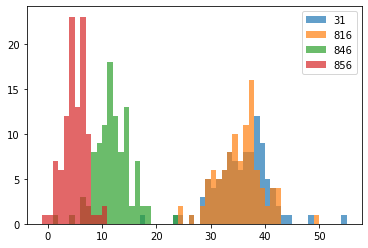

In [16]:
run_test(t[mid], s[mid], [31,816,846,856])

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 152.83it/s, avg_epoch_loss=1.14]
INFO:root:Epoch[0] Elapsed time 0.656 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.141580
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 159.81it/s, avg_epoch_loss=0.596]
INFO:root:Epoch[1] Elapsed time 0.628 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.595711
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 161.89it/s, avg_epoch_loss=0.456]
INFO:root:Epoch[2] Elapsed time 0.619 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.456367
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 164.17it/s, avg_epoch_loss=0.41]
INFO:root:Epoch[3] Elapsed time 0.611 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.410288
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 166.71it/s

100%|██████████| 100/100 [00:00<00:00, 166.82it/s, avg_epoch_loss=0.103]
INFO:root:Epoch[36] Elapsed time 0.601 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=0.102995
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 165.69it/s, avg_epoch_loss=0.147]
INFO:root:Epoch[37] Elapsed time 0.605 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.146636
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 165.12it/s, avg_epoch_loss=0.0906]
INFO:root:Epoch[38] Elapsed time 0.607 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.090615
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 164.28it/s, avg_epoch_loss=0.112]
INFO:root:Epoch[39] Elapsed time 0.610 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.111911
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 163.85it/s, avg_epoch_loss=0.133]
INFO:root:Epoch[40] Elapsed time 0

INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 162.96it/s, avg_epoch_loss=0.084]
INFO:root:Epoch[73] Elapsed time 0.615 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.084047
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 166.87it/s, avg_epoch_loss=0.117]
INFO:root:Epoch[74] Elapsed time 0.601 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.117112
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 163.11it/s, avg_epoch_loss=0.0751]
INFO:root:Epoch[75] Elapsed time 0.615 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.075140
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 163.17it/s, avg_epoch_loss=0.107]
INFO:root:Epoch[76] Elapsed time 0.614 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.107110
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 162.93it/s, avg_epoch_los

INFO:root:Epoch[109] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 162.74it/s, avg_epoch_loss=0.0856]
INFO:root:Epoch[109] Elapsed time 0.616 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.085632
INFO:root:Epoch[110] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 161.06it/s, avg_epoch_loss=0.106]
INFO:root:Epoch[110] Elapsed time 0.623 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.106317
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 161.61it/s, avg_epoch_loss=0.0882]
INFO:root:Epoch[111] Elapsed time 0.621 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.088242
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 163.33it/s, avg_epoch_loss=0.0813]
INFO:root:Epoch[112] Elapsed time 0.614 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=0.081318
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 

100%|██████████| 100/100 [00:00<00:00, 159.73it/s, avg_epoch_loss=0.106]
INFO:root:Epoch[144] Elapsed time 0.628 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=0.106429
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.41it/s, avg_epoch_loss=0.0757]
INFO:root:Epoch[145] Elapsed time 0.621 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.075703
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.20it/s, avg_epoch_loss=0.0686]
INFO:root:Epoch[146] Elapsed time 0.622 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.068646
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.67it/s, avg_epoch_loss=0.0978]
INFO:root:Epoch[147] Elapsed time 0.616 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.097832
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.12it/s, avg_epoch_loss=0.074]
INFO:root:Epoch[148]

100%|██████████| 100/100 [00:00<00:00, 164.33it/s, avg_epoch_loss=0.0781]
INFO:root:Epoch[180] Elapsed time 0.610 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.078063
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.80it/s, avg_epoch_loss=0.118]
INFO:root:Epoch[181] Elapsed time 0.601 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.118407
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.86it/s, avg_epoch_loss=0.0824]
INFO:root:Epoch[182] Elapsed time 0.605 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.082354
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.62it/s, avg_epoch_loss=0.0967]
INFO:root:Epoch[183] Elapsed time 0.605 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.096712
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.49it/s, avg_epoch_loss=0.0862]
INFO:root:Epoch[184

100%|██████████| 100/100 [00:00<00:00, 165.74it/s, avg_epoch_loss=0.0792]
INFO:root:Epoch[216] Elapsed time 0.605 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.079234
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.52it/s, avg_epoch_loss=0.0967]
INFO:root:Epoch[217] Elapsed time 0.613 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.096737
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.54it/s, avg_epoch_loss=0.0728]
INFO:root:Epoch[218] Elapsed time 0.613 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.072799
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.75it/s, avg_epoch_loss=0.069]
INFO:root:Epoch[219] Elapsed time 0.612 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.069007
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.95it/s, avg_epoch_loss=0.0934]
INFO:root:Epoch[220

100%|██████████| 100/100 [00:00<00:00, 167.48it/s, avg_epoch_loss=0.0739]
INFO:root:Epoch[252] Elapsed time 0.599 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=0.073940
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.74it/s, avg_epoch_loss=0.0727]
INFO:root:Epoch[253] Elapsed time 0.598 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.072678
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.22it/s, avg_epoch_loss=0.0797]
INFO:root:Epoch[254] Elapsed time 0.600 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.079671
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.05it/s, avg_epoch_loss=0.0698]
INFO:root:Epoch[255] Elapsed time 0.608 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.069848
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.34it/s, avg_epoch_loss=0.0993]
INFO:root:Epoch[25

100%|██████████| 100/100 [00:00<00:00, 161.63it/s, avg_epoch_loss=0.0819]
INFO:root:Epoch[288] Elapsed time 0.620 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=0.081938
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.56it/s, avg_epoch_loss=0.0775]
INFO:root:Epoch[289] Elapsed time 0.598 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.077470
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.71it/s, avg_epoch_loss=0.0852]
INFO:root:Epoch[290] Elapsed time 0.616 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.085169
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.42it/s, avg_epoch_loss=0.0679]
INFO:root:Epoch[291] Elapsed time 0.614 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.067947
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.23it/s, avg_epoch_loss=0.0644]
INFO:root:Epoch[29

100%|██████████| 100/100 [00:00<00:00, 162.39it/s, avg_epoch_loss=0.089]
INFO:root:Epoch[324] Elapsed time 0.617 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.088960
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.05it/s, avg_epoch_loss=0.085]
INFO:root:Epoch[325] Elapsed time 0.619 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.085013
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.00it/s, avg_epoch_loss=0.0726]
INFO:root:Epoch[326] Elapsed time 0.619 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.072560
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.13it/s, avg_epoch_loss=0.0781]
INFO:root:Epoch[327] Elapsed time 0.619 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.078148
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.05it/s, avg_epoch_loss=0.0878]
INFO:root:Epoch[328]

100%|██████████| 100/100 [00:00<00:00, 163.52it/s, avg_epoch_loss=0.109]
INFO:root:Epoch[360] Elapsed time 0.613 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=0.109145
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.97it/s, avg_epoch_loss=0.0859]
INFO:root:Epoch[361] Elapsed time 0.631 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.085909
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.75it/s, avg_epoch_loss=0.0658]
INFO:root:Epoch[362] Elapsed time 0.616 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.065780
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.18it/s, avg_epoch_loss=0.105]
INFO:root:Epoch[363] Elapsed time 0.611 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.105053
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.03it/s, avg_epoch_loss=0.099]
INFO:root:Epoch[364] 

100%|██████████| 100/100 [00:00<00:00, 165.78it/s, avg_epoch_loss=0.109]
INFO:root:Epoch[396] Elapsed time 0.605 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=0.108670
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.81it/s, avg_epoch_loss=0.0805]
INFO:root:Epoch[397] Elapsed time 0.620 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.080455
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.66it/s, avg_epoch_loss=0.0905]
INFO:root:Epoch[398] Elapsed time 0.602 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.090486
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.37it/s, avg_epoch_loss=0.0793]
INFO:root:Epoch[399] Elapsed time 0.610 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.079285
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.02it/s, avg_epoch_loss=0.0744]
INFO:root:Epoch[400

100%|██████████| 100/100 [00:00<00:00, 163.38it/s, avg_epoch_loss=0.0859]
INFO:root:Epoch[432] Elapsed time 0.614 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.085874
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.59it/s, avg_epoch_loss=0.112]
INFO:root:Epoch[433] Elapsed time 0.591 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.112053
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.83it/s, avg_epoch_loss=0.0879]
INFO:root:Epoch[434] Elapsed time 0.608 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.087851
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.85it/s, avg_epoch_loss=0.0774]
INFO:root:Epoch[435] Elapsed time 0.612 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.077354
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.66it/s, avg_epoch_loss=0.0849]
INFO:root:Epoch[436

100%|██████████| 100/100 [00:00<00:00, 166.00it/s, avg_epoch_loss=0.0758]
INFO:root:Epoch[468] Elapsed time 0.605 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=0.075760
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.22it/s, avg_epoch_loss=0.114]
INFO:root:Epoch[469] Elapsed time 0.603 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.113771
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.80it/s, avg_epoch_loss=0.0805]
INFO:root:Epoch[470] Elapsed time 0.608 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.080453
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.83it/s, avg_epoch_loss=0.0864]
INFO:root:Epoch[471] Elapsed time 0.612 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.086375
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.42it/s, avg_epoch_loss=0.1]
INFO:root:Epoch[472] E

100%|██████████| 100/100 [00:00<00:00, 169.63it/s, avg_epoch_loss=0.106]
INFO:root:Epoch[504] Elapsed time 0.591 seconds
INFO:root:Epoch[504] Evaluation metric 'epoch_loss'=0.106042
INFO:root:Epoch[505] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.23it/s, avg_epoch_loss=0.0852]
INFO:root:Epoch[505] Elapsed time 0.611 seconds
INFO:root:Epoch[505] Evaluation metric 'epoch_loss'=0.085199
INFO:root:Epoch[506] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.34it/s, avg_epoch_loss=0.106]
INFO:root:Epoch[506] Elapsed time 0.610 seconds
INFO:root:Epoch[506] Evaluation metric 'epoch_loss'=0.106224
INFO:root:Epoch[507] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.03it/s, avg_epoch_loss=0.067]
INFO:root:Epoch[507] Elapsed time 0.611 seconds
INFO:root:Epoch[507] Evaluation metric 'epoch_loss'=0.066981
INFO:root:Epoch[508] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.79it/s, avg_epoch_loss=0.0906]
INFO:root:Epoch[508] 

100%|██████████| 100/100 [00:00<00:00, 171.34it/s, avg_epoch_loss=0.102]
INFO:root:Epoch[540] Elapsed time 0.585 seconds
INFO:root:Epoch[540] Evaluation metric 'epoch_loss'=0.102245
INFO:root:Epoch[541] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.69it/s, avg_epoch_loss=0.0635]
INFO:root:Epoch[541] Elapsed time 0.605 seconds
INFO:root:Epoch[541] Evaluation metric 'epoch_loss'=0.063549
INFO:root:Epoch[542] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.60it/s, avg_epoch_loss=0.107]
INFO:root:Epoch[542] Elapsed time 0.613 seconds
INFO:root:Epoch[542] Evaluation metric 'epoch_loss'=0.106614
INFO:root:Epoch[543] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.34it/s, avg_epoch_loss=0.0744]
INFO:root:Epoch[543] Elapsed time 0.589 seconds
INFO:root:Epoch[543] Evaluation metric 'epoch_loss'=0.074417
INFO:root:Epoch[544] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.95it/s, avg_epoch_loss=0.0807]
INFO:root:Epoch[544]

100%|██████████| 100/100 [00:00<00:00, 167.41it/s, avg_epoch_loss=0.0869]
INFO:root:Epoch[576] Elapsed time 0.599 seconds
INFO:root:Epoch[576] Evaluation metric 'epoch_loss'=0.086949
INFO:root:Epoch[577] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.52it/s, avg_epoch_loss=0.0806]
INFO:root:Epoch[577] Elapsed time 0.606 seconds
INFO:root:Epoch[577] Evaluation metric 'epoch_loss'=0.080564
INFO:root:Epoch[578] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.66it/s, avg_epoch_loss=0.043]
INFO:root:Epoch[578] Elapsed time 0.605 seconds
INFO:root:Epoch[578] Evaluation metric 'epoch_loss'=0.043014
INFO:root:Epoch[579] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.05it/s, avg_epoch_loss=0.0907]
INFO:root:Epoch[579] Elapsed time 0.597 seconds
INFO:root:Epoch[579] Evaluation metric 'epoch_loss'=0.090685
INFO:root:Epoch[580] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.52it/s, avg_epoch_loss=0.0819]
INFO:root:Epoch[580

100%|██████████| 100/100 [00:00<00:00, 162.00it/s, avg_epoch_loss=0.065]
INFO:root:Epoch[612] Elapsed time 0.619 seconds
INFO:root:Epoch[612] Evaluation metric 'epoch_loss'=0.065039
INFO:root:Epoch[613] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.35it/s, avg_epoch_loss=0.105]
INFO:root:Epoch[613] Elapsed time 0.622 seconds
INFO:root:Epoch[613] Evaluation metric 'epoch_loss'=0.104823
INFO:root:Epoch[614] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.86it/s, avg_epoch_loss=0.0564]
INFO:root:Epoch[614] Elapsed time 0.619 seconds
INFO:root:Epoch[614] Evaluation metric 'epoch_loss'=0.056371
INFO:root:Epoch[615] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.94it/s, avg_epoch_loss=0.0999]
INFO:root:Epoch[615] Elapsed time 0.631 seconds
INFO:root:Epoch[615] Evaluation metric 'epoch_loss'=0.099886
INFO:root:Epoch[616] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.04it/s, avg_epoch_loss=0.0774]
INFO:root:Epoch[616]

100%|██████████| 100/100 [00:00<00:00, 160.95it/s, avg_epoch_loss=0.0904]
INFO:root:Epoch[648] Elapsed time 0.623 seconds
INFO:root:Epoch[648] Evaluation metric 'epoch_loss'=0.090378
INFO:root:Epoch[649] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.13it/s, avg_epoch_loss=0.119]
INFO:root:Epoch[649] Elapsed time 0.615 seconds
INFO:root:Epoch[649] Evaluation metric 'epoch_loss'=0.119097
INFO:root:Epoch[650] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.23it/s, avg_epoch_loss=0.0819]
INFO:root:Epoch[650] Elapsed time 0.626 seconds
INFO:root:Epoch[650] Evaluation metric 'epoch_loss'=0.081897
INFO:root:Epoch[651] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.77it/s, avg_epoch_loss=0.0757]
INFO:root:Epoch[651] Elapsed time 0.616 seconds
INFO:root:Epoch[651] Evaluation metric 'epoch_loss'=0.075672
INFO:root:Epoch[652] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.06it/s, avg_epoch_loss=0.0953]
INFO:root:Epoch[652

100%|██████████| 100/100 [00:00<00:00, 156.97it/s, avg_epoch_loss=0.0905]
INFO:root:Epoch[684] Elapsed time 0.639 seconds
INFO:root:Epoch[684] Evaluation metric 'epoch_loss'=0.090536
INFO:root:Epoch[685] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.24it/s, avg_epoch_loss=0.0794]
INFO:root:Epoch[685] Elapsed time 0.642 seconds
INFO:root:Epoch[685] Evaluation metric 'epoch_loss'=0.079392
INFO:root:Epoch[686] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.07it/s, avg_epoch_loss=0.104]
INFO:root:Epoch[686] Elapsed time 0.642 seconds
INFO:root:Epoch[686] Evaluation metric 'epoch_loss'=0.103948
INFO:root:Epoch[687] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.05it/s, avg_epoch_loss=0.0676]
INFO:root:Epoch[687] Elapsed time 0.638 seconds
INFO:root:Epoch[687] Evaluation metric 'epoch_loss'=0.067627
INFO:root:Epoch[688] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.00it/s, avg_epoch_loss=0.0986]
INFO:root:Epoch[688

100%|██████████| 100/100 [00:00<00:00, 164.80it/s, avg_epoch_loss=0.0853]
INFO:root:Epoch[720] Elapsed time 0.608 seconds
INFO:root:Epoch[720] Evaluation metric 'epoch_loss'=0.085276
INFO:root:Epoch[721] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.85it/s, avg_epoch_loss=0.0637]
INFO:root:Epoch[721] Elapsed time 0.623 seconds
INFO:root:Epoch[721] Evaluation metric 'epoch_loss'=0.063709
INFO:root:Epoch[722] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.09it/s, avg_epoch_loss=0.097]
INFO:root:Epoch[722] Elapsed time 0.615 seconds
INFO:root:Epoch[722] Evaluation metric 'epoch_loss'=0.096965
INFO:root:Epoch[723] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.50it/s, avg_epoch_loss=0.0792]
INFO:root:Epoch[723] Elapsed time 0.602 seconds
INFO:root:Epoch[723] Evaluation metric 'epoch_loss'=0.079188
INFO:root:Epoch[724] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.25it/s, avg_epoch_loss=0.0738]
INFO:root:Epoch[724

100%|██████████| 100/100 [00:00<00:00, 165.79it/s, avg_epoch_loss=0.0813]
INFO:root:Epoch[756] Elapsed time 0.605 seconds
INFO:root:Epoch[756] Evaluation metric 'epoch_loss'=0.081301
INFO:root:Epoch[757] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.08it/s, avg_epoch_loss=0.0797]
INFO:root:Epoch[757] Elapsed time 0.611 seconds
INFO:root:Epoch[757] Evaluation metric 'epoch_loss'=0.079663
INFO:root:Epoch[758] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.26it/s, avg_epoch_loss=0.0853]
INFO:root:Epoch[758] Elapsed time 0.614 seconds
INFO:root:Epoch[758] Evaluation metric 'epoch_loss'=0.085296
INFO:root:Epoch[759] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.31it/s, avg_epoch_loss=0.0489]
INFO:root:Epoch[759] Elapsed time 0.618 seconds
INFO:root:Epoch[759] Evaluation metric 'epoch_loss'=0.048926
INFO:root:Epoch[760] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.20it/s, avg_epoch_loss=0.0692]
INFO:root:Epoch[76

100%|██████████| 100/100 [00:00<00:00, 166.88it/s, avg_epoch_loss=0.0867]
INFO:root:Epoch[792] Elapsed time 0.601 seconds
INFO:root:Epoch[792] Evaluation metric 'epoch_loss'=0.086713
INFO:root:Epoch[793] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.48it/s, avg_epoch_loss=0.104]
INFO:root:Epoch[793] Elapsed time 0.606 seconds
INFO:root:Epoch[793] Evaluation metric 'epoch_loss'=0.103788
INFO:root:Epoch[794] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.86it/s, avg_epoch_loss=0.0902]
INFO:root:Epoch[794] Elapsed time 0.604 seconds
INFO:root:Epoch[794] Evaluation metric 'epoch_loss'=0.090243
INFO:root:Epoch[795] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.46it/s, avg_epoch_loss=0.0918]
INFO:root:Epoch[795] Elapsed time 0.602 seconds
INFO:root:Epoch[795] Evaluation metric 'epoch_loss'=0.091757
INFO:root:Epoch[796] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.26it/s, avg_epoch_loss=0.0611]
INFO:root:Epoch[796

100%|██████████| 100/100 [00:00<00:00, 166.52it/s, avg_epoch_loss=0.0576]
INFO:root:Epoch[828] Elapsed time 0.602 seconds
INFO:root:Epoch[828] Evaluation metric 'epoch_loss'=0.057574
INFO:root:Epoch[829] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.24it/s, avg_epoch_loss=0.0923]
INFO:root:Epoch[829] Elapsed time 0.596 seconds
INFO:root:Epoch[829] Evaluation metric 'epoch_loss'=0.092297
INFO:root:Epoch[830] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.87it/s, avg_epoch_loss=0.0789]
INFO:root:Epoch[830] Elapsed time 0.598 seconds
INFO:root:Epoch[830] Evaluation metric 'epoch_loss'=0.078926
INFO:root:Epoch[831] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.52it/s, avg_epoch_loss=0.0769]
INFO:root:Epoch[831] Elapsed time 0.602 seconds
INFO:root:Epoch[831] Evaluation metric 'epoch_loss'=0.076929
INFO:root:Epoch[832] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.77it/s, avg_epoch_loss=0.0834]
INFO:root:Epoch[83

100%|██████████| 100/100 [00:00<00:00, 162.70it/s, avg_epoch_loss=0.0801]
INFO:root:Epoch[864] Elapsed time 0.616 seconds
INFO:root:Epoch[864] Evaluation metric 'epoch_loss'=0.080095
INFO:root:Epoch[865] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.36it/s, avg_epoch_loss=0.0739]
INFO:root:Epoch[865] Elapsed time 0.621 seconds
INFO:root:Epoch[865] Evaluation metric 'epoch_loss'=0.073929
INFO:root:Epoch[866] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.50it/s, avg_epoch_loss=0.081]
INFO:root:Epoch[866] Elapsed time 0.610 seconds
INFO:root:Epoch[866] Evaluation metric 'epoch_loss'=0.080994
INFO:root:Epoch[867] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.63it/s, avg_epoch_loss=0.0887]
INFO:root:Epoch[867] Elapsed time 0.613 seconds
INFO:root:Epoch[867] Evaluation metric 'epoch_loss'=0.088664
INFO:root:Epoch[868] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.87it/s, avg_epoch_loss=0.104]
INFO:root:Epoch[868]

100%|██████████| 100/100 [00:00<00:00, 159.18it/s, avg_epoch_loss=0.082]
INFO:root:Epoch[900] Elapsed time 0.630 seconds
INFO:root:Epoch[900] Evaluation metric 'epoch_loss'=0.082008
INFO:root:Epoch[901] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.80it/s, avg_epoch_loss=0.0745]
INFO:root:Epoch[901] Elapsed time 0.616 seconds
INFO:root:Epoch[901] Evaluation metric 'epoch_loss'=0.074516
INFO:root:Epoch[902] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.16it/s, avg_epoch_loss=0.0852]
INFO:root:Epoch[902] Elapsed time 0.614 seconds
INFO:root:Epoch[902] Evaluation metric 'epoch_loss'=0.085245
INFO:root:Epoch[903] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.50it/s, avg_epoch_loss=0.0646]
INFO:root:Epoch[903] Elapsed time 0.617 seconds
INFO:root:Epoch[903] Evaluation metric 'epoch_loss'=0.064622
INFO:root:Epoch[904] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.57it/s, avg_epoch_loss=0.083]
INFO:root:Epoch[904]

100%|██████████| 100/100 [00:00<00:00, 162.45it/s, avg_epoch_loss=0.0825]
INFO:root:Epoch[936] Elapsed time 0.617 seconds
INFO:root:Epoch[936] Evaluation metric 'epoch_loss'=0.082528
INFO:root:Epoch[937] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.90it/s, avg_epoch_loss=0.0851]
INFO:root:Epoch[937] Elapsed time 0.612 seconds
INFO:root:Epoch[937] Evaluation metric 'epoch_loss'=0.085089
INFO:root:Epoch[938] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.57it/s, avg_epoch_loss=0.0791]
INFO:root:Epoch[938] Elapsed time 0.599 seconds
INFO:root:Epoch[938] Evaluation metric 'epoch_loss'=0.079101
INFO:root:Epoch[939] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.91it/s, avg_epoch_loss=0.0964]
INFO:root:Epoch[939] Elapsed time 0.608 seconds
INFO:root:Epoch[939] Evaluation metric 'epoch_loss'=0.096431
INFO:root:Epoch[940] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.33it/s, avg_epoch_loss=0.0913]
INFO:root:Epoch[94

100%|██████████| 100/100 [00:00<00:00, 163.13it/s, avg_epoch_loss=0.0984]
INFO:root:Epoch[972] Elapsed time 0.615 seconds
INFO:root:Epoch[972] Evaluation metric 'epoch_loss'=0.098428
INFO:root:Epoch[973] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.58it/s, avg_epoch_loss=0.0659]
INFO:root:Epoch[973] Elapsed time 0.609 seconds
INFO:root:Epoch[973] Evaluation metric 'epoch_loss'=0.065868
INFO:root:Epoch[974] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.38it/s, avg_epoch_loss=0.077]
INFO:root:Epoch[974] Elapsed time 0.617 seconds
INFO:root:Epoch[974] Evaluation metric 'epoch_loss'=0.076981
INFO:root:Epoch[975] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.22it/s, avg_epoch_loss=0.111]
INFO:root:Epoch[975] Elapsed time 0.607 seconds
INFO:root:Epoch[975] Evaluation metric 'epoch_loss'=0.110990
INFO:root:Epoch[976] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.90it/s, avg_epoch_loss=0.0814]
INFO:root:Epoch[976]

100%|██████████| 100/100 [00:00<00:00, 161.68it/s, avg_epoch_loss=0.103]
INFO:root:Epoch[1008] Elapsed time 0.620 seconds
INFO:root:Epoch[1008] Evaluation metric 'epoch_loss'=0.102560
INFO:root:Epoch[1009] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.89it/s, avg_epoch_loss=0.0514]
INFO:root:Epoch[1009] Elapsed time 0.627 seconds
INFO:root:Epoch[1009] Evaluation metric 'epoch_loss'=0.051444
INFO:root:Epoch[1010] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.43it/s, avg_epoch_loss=0.073]
INFO:root:Epoch[1010] Elapsed time 0.629 seconds
INFO:root:Epoch[1010] Evaluation metric 'epoch_loss'=0.072967
INFO:root:Epoch[1011] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.79it/s, avg_epoch_loss=0.0701]
INFO:root:Epoch[1011] Elapsed time 0.631 seconds
INFO:root:Epoch[1011] Evaluation metric 'epoch_loss'=0.070132
INFO:root:Epoch[1012] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.41it/s, avg_epoch_loss=0.0817]
INFO:roo

INFO:root:Epoch[1044] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.02it/s, avg_epoch_loss=0.0731]
INFO:root:Epoch[1044] Elapsed time 0.593 seconds
INFO:root:Epoch[1044] Evaluation metric 'epoch_loss'=0.073135
INFO:root:Epoch[1045] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.31it/s, avg_epoch_loss=0.0921]
INFO:root:Epoch[1045] Elapsed time 0.589 seconds
INFO:root:Epoch[1045] Evaluation metric 'epoch_loss'=0.092083
INFO:root:Epoch[1046] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.50it/s, avg_epoch_loss=0.09]
INFO:root:Epoch[1046] Elapsed time 0.606 seconds
INFO:root:Epoch[1046] Evaluation metric 'epoch_loss'=0.090009
INFO:root:Epoch[1047] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.27it/s, avg_epoch_loss=0.0893]
INFO:root:Epoch[1047] Elapsed time 0.600 seconds
INFO:root:Epoch[1047] Evaluation metric 'epoch_loss'=0.089350
INFO:root:Epoch[1048] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00

INFO:root:Epoch[1079] Evaluation metric 'epoch_loss'=0.088212
INFO:root:Epoch[1080] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.50it/s, avg_epoch_loss=0.0702]
INFO:root:Epoch[1080] Elapsed time 0.621 seconds
INFO:root:Epoch[1080] Evaluation metric 'epoch_loss'=0.070151
INFO:root:Epoch[1081] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.33it/s, avg_epoch_loss=0.106]
INFO:root:Epoch[1081] Elapsed time 0.625 seconds
INFO:root:Epoch[1081] Evaluation metric 'epoch_loss'=0.106397
INFO:root:Epoch[1082] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.07it/s, avg_epoch_loss=0.0704]
INFO:root:Epoch[1082] Elapsed time 0.619 seconds
INFO:root:Epoch[1082] Evaluation metric 'epoch_loss'=0.070433
INFO:root:Epoch[1083] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.14it/s, avg_epoch_loss=0.0742]
INFO:root:Epoch[1083] Elapsed time 0.615 seconds
INFO:root:Epoch[1083] Evaluation metric 'epoch_loss'=0.074249
INFO:root:Epoch[108

100%|██████████| 100/100 [00:00<00:00, 159.92it/s, avg_epoch_loss=0.0845]
INFO:root:Epoch[1115] Elapsed time 0.627 seconds
INFO:root:Epoch[1115] Evaluation metric 'epoch_loss'=0.084542
INFO:root:Epoch[1116] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.72it/s, avg_epoch_loss=0.0734]
INFO:root:Epoch[1116] Elapsed time 0.616 seconds
INFO:root:Epoch[1116] Evaluation metric 'epoch_loss'=0.073354
INFO:root:Epoch[1117] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.45it/s, avg_epoch_loss=0.0654]
INFO:root:Epoch[1117] Elapsed time 0.610 seconds
INFO:root:Epoch[1117] Evaluation metric 'epoch_loss'=0.065386
INFO:root:Epoch[1118] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.53it/s, avg_epoch_loss=0.0961]
INFO:root:Epoch[1118] Elapsed time 0.602 seconds
INFO:root:Epoch[1118] Evaluation metric 'epoch_loss'=0.096051
INFO:root:Epoch[1119] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.50it/s, avg_epoch_loss=0.0804]
INFO:r

INFO:root:Epoch[1151] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.91it/s, avg_epoch_loss=0.0953]
INFO:root:Epoch[1151] Elapsed time 0.631 seconds
INFO:root:Epoch[1151] Evaluation metric 'epoch_loss'=0.095316
INFO:root:Epoch[1152] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.17it/s, avg_epoch_loss=0.0629]
INFO:root:Epoch[1152] Elapsed time 0.622 seconds
INFO:root:Epoch[1152] Evaluation metric 'epoch_loss'=0.062920
INFO:root:Epoch[1153] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.33it/s, avg_epoch_loss=0.0793]
INFO:root:Epoch[1153] Elapsed time 0.621 seconds
INFO:root:Epoch[1153] Evaluation metric 'epoch_loss'=0.079313
INFO:root:Epoch[1154] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.27it/s, avg_epoch_loss=0.098]
INFO:root:Epoch[1154] Elapsed time 0.626 seconds
INFO:root:Epoch[1154] Evaluation metric 'epoch_loss'=0.097962
INFO:root:Epoch[1155] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:0

INFO:root:Epoch[1186] Evaluation metric 'epoch_loss'=0.091085
INFO:root:Epoch[1187] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.20it/s, avg_epoch_loss=0.0784]
INFO:root:Epoch[1187] Elapsed time 0.600 seconds
INFO:root:Epoch[1187] Evaluation metric 'epoch_loss'=0.078361
INFO:root:Epoch[1188] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.71it/s, avg_epoch_loss=0.0932]
INFO:root:Epoch[1188] Elapsed time 0.602 seconds
INFO:root:Epoch[1188] Evaluation metric 'epoch_loss'=0.093192
INFO:root:Epoch[1189] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.89it/s, avg_epoch_loss=0.0627]
INFO:root:Epoch[1189] Elapsed time 0.616 seconds
INFO:root:Epoch[1189] Evaluation metric 'epoch_loss'=0.062653
INFO:root:Epoch[1190] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.12it/s, avg_epoch_loss=0.0603]
INFO:root:Epoch[1190] Elapsed time 0.615 seconds
INFO:root:Epoch[1190] Evaluation metric 'epoch_loss'=0.060262
INFO:root:Epoch[11

100%|██████████| 100/100 [00:00<00:00, 158.05it/s, avg_epoch_loss=0.0752]
INFO:root:Epoch[1222] Elapsed time 0.634 seconds
INFO:root:Epoch[1222] Evaluation metric 'epoch_loss'=0.075226
INFO:root:Epoch[1223] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.81it/s, avg_epoch_loss=0.0923]
INFO:root:Epoch[1223] Elapsed time 0.616 seconds
INFO:root:Epoch[1223] Evaluation metric 'epoch_loss'=0.092298
INFO:root:Epoch[1224] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.28it/s, avg_epoch_loss=0.0784]
INFO:root:Epoch[1224] Elapsed time 0.626 seconds
INFO:root:Epoch[1224] Evaluation metric 'epoch_loss'=0.078396
INFO:root:Epoch[1225] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.01it/s, avg_epoch_loss=0.0866]
INFO:root:Epoch[1225] Elapsed time 0.623 seconds
INFO:root:Epoch[1225] Evaluation metric 'epoch_loss'=0.086555
INFO:root:Epoch[1226] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.18it/s, avg_epoch_loss=0.0643]
INFO:r

INFO:root:Epoch[1258] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.87it/s, avg_epoch_loss=0.0799]
INFO:root:Epoch[1258] Elapsed time 0.620 seconds
INFO:root:Epoch[1258] Evaluation metric 'epoch_loss'=0.079868
INFO:root:Epoch[1259] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.79it/s, avg_epoch_loss=0.0852]
INFO:root:Epoch[1259] Elapsed time 0.624 seconds
INFO:root:Epoch[1259] Evaluation metric 'epoch_loss'=0.085208
INFO:root:Epoch[1260] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.53it/s, avg_epoch_loss=0.0834]
INFO:root:Epoch[1260] Elapsed time 0.625 seconds
INFO:root:Epoch[1260] Evaluation metric 'epoch_loss'=0.083389
INFO:root:Epoch[1261] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.28it/s, avg_epoch_loss=0.108]
INFO:root:Epoch[1261] Elapsed time 0.626 seconds
INFO:root:Epoch[1261] Evaluation metric 'epoch_loss'=0.108386
INFO:root:Epoch[1262] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:0

INFO:root:Epoch[1293] Evaluation metric 'epoch_loss'=0.086245
INFO:root:Epoch[1294] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 150.31it/s, avg_epoch_loss=0.0636]
INFO:root:Epoch[1294] Elapsed time 0.667 seconds
INFO:root:Epoch[1294] Evaluation metric 'epoch_loss'=0.063606
INFO:root:Epoch[1295] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.11it/s, avg_epoch_loss=0.0785]
INFO:root:Epoch[1295] Elapsed time 0.622 seconds
INFO:root:Epoch[1295] Evaluation metric 'epoch_loss'=0.078458
INFO:root:Epoch[1296] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.71it/s, avg_epoch_loss=0.0675]
INFO:root:Epoch[1296] Elapsed time 0.616 seconds
INFO:root:Epoch[1296] Evaluation metric 'epoch_loss'=0.067525
INFO:root:Epoch[1297] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.60it/s, avg_epoch_loss=0.074]
INFO:root:Epoch[1297] Elapsed time 0.620 seconds
INFO:root:Epoch[1297] Evaluation metric 'epoch_loss'=0.073995
INFO:root:Epoch[129

100%|██████████| 100/100 [00:00<00:00, 165.96it/s, avg_epoch_loss=0.067]
INFO:root:Epoch[1329] Elapsed time 0.604 seconds
INFO:root:Epoch[1329] Evaluation metric 'epoch_loss'=0.067028
INFO:root:Epoch[1330] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.07it/s, avg_epoch_loss=0.0663]
INFO:root:Epoch[1330] Elapsed time 0.611 seconds
INFO:root:Epoch[1330] Evaluation metric 'epoch_loss'=0.066265
INFO:root:Epoch[1331] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.14it/s, avg_epoch_loss=0.086]
INFO:root:Epoch[1331] Elapsed time 0.596 seconds
INFO:root:Epoch[1331] Evaluation metric 'epoch_loss'=0.086013
INFO:root:Epoch[1332] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.12it/s, avg_epoch_loss=0.0817]
INFO:root:Epoch[1332] Elapsed time 0.607 seconds
INFO:root:Epoch[1332] Evaluation metric 'epoch_loss'=0.081666
INFO:root:Epoch[1333] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.72it/s, avg_epoch_loss=0.092]
INFO:root

INFO:root:Epoch[1365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.38it/s, avg_epoch_loss=0.0829]
INFO:root:Epoch[1365] Elapsed time 0.610 seconds
INFO:root:Epoch[1365] Evaluation metric 'epoch_loss'=0.082885
INFO:root:Epoch[1366] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.37it/s, avg_epoch_loss=0.0732]
INFO:root:Epoch[1366] Elapsed time 0.610 seconds
INFO:root:Epoch[1366] Evaluation metric 'epoch_loss'=0.073205
INFO:root:Epoch[1367] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.58it/s, avg_epoch_loss=0.0584]
INFO:root:Epoch[1367] Elapsed time 0.602 seconds
INFO:root:Epoch[1367] Evaluation metric 'epoch_loss'=0.058393
INFO:root:Epoch[1368] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.48it/s, avg_epoch_loss=0.0935]
INFO:root:Epoch[1368] Elapsed time 0.606 seconds
INFO:root:Epoch[1368] Evaluation metric 'epoch_loss'=0.093487
INFO:root:Epoch[1369] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1400] Evaluation metric 'epoch_loss'=0.068088
INFO:root:Epoch[1401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.46it/s, avg_epoch_loss=0.101]
INFO:root:Epoch[1401] Elapsed time 0.658 seconds
INFO:root:Epoch[1401] Evaluation metric 'epoch_loss'=0.101132
INFO:root:Epoch[1402] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.26it/s, avg_epoch_loss=0.0488]
INFO:root:Epoch[1402] Elapsed time 0.650 seconds
INFO:root:Epoch[1402] Evaluation metric 'epoch_loss'=0.048802
INFO:root:Epoch[1403] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.19it/s, avg_epoch_loss=0.0742]
INFO:root:Epoch[1403] Elapsed time 0.650 seconds
INFO:root:Epoch[1403] Evaluation metric 'epoch_loss'=0.074164
INFO:root:Epoch[1404] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.20it/s, avg_epoch_loss=0.0763]
INFO:root:Epoch[1404] Elapsed time 0.659 seconds
INFO:root:Epoch[1404] Evaluation metric 'epoch_loss'=0.076348
INFO:root:Epoch[140

100%|██████████| 100/100 [00:00<00:00, 167.71it/s, avg_epoch_loss=0.0632]
INFO:root:Epoch[1436] Elapsed time 0.598 seconds
INFO:root:Epoch[1436] Evaluation metric 'epoch_loss'=0.063159
INFO:root:Epoch[1437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.71it/s, avg_epoch_loss=0.0789]
INFO:root:Epoch[1437] Elapsed time 0.609 seconds
INFO:root:Epoch[1437] Evaluation metric 'epoch_loss'=0.078869
INFO:root:Epoch[1438] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.33it/s, avg_epoch_loss=0.0811]
INFO:root:Epoch[1438] Elapsed time 0.599 seconds
INFO:root:Epoch[1438] Evaluation metric 'epoch_loss'=0.081114
INFO:root:Epoch[1439] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.72it/s, avg_epoch_loss=0.0733]
INFO:root:Epoch[1439] Elapsed time 0.602 seconds
INFO:root:Epoch[1439] Evaluation metric 'epoch_loss'=0.073320
INFO:root:Epoch[1440] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.44it/s, avg_epoch_loss=0.0563]
INFO:r

INFO:root:Epoch[1472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.22it/s, avg_epoch_loss=0.0837]
INFO:root:Epoch[1472] Elapsed time 0.611 seconds
INFO:root:Epoch[1472] Evaluation metric 'epoch_loss'=0.083700
INFO:root:Epoch[1473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.80it/s, avg_epoch_loss=0.0686]
INFO:root:Epoch[1473] Elapsed time 0.620 seconds
INFO:root:Epoch[1473] Evaluation metric 'epoch_loss'=0.068550
INFO:root:Epoch[1474] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.94it/s, avg_epoch_loss=0.1]
INFO:root:Epoch[1474] Elapsed time 0.623 seconds
INFO:root:Epoch[1474] Evaluation metric 'epoch_loss'=0.100340
INFO:root:Epoch[1475] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.22it/s, avg_epoch_loss=0.0739]
INFO:root:Epoch[1475] Elapsed time 0.611 seconds
INFO:root:Epoch[1475] Evaluation metric 'epoch_loss'=0.073899
INFO:root:Epoch[1476] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00,

INFO:root:Epoch[1507] Evaluation metric 'epoch_loss'=0.079911
INFO:root:Epoch[1508] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.79it/s, avg_epoch_loss=0.0991]
INFO:root:Epoch[1508] Elapsed time 0.627 seconds
INFO:root:Epoch[1508] Evaluation metric 'epoch_loss'=0.099149
INFO:root:Epoch[1509] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.54it/s, avg_epoch_loss=0.0712]
INFO:root:Epoch[1509] Elapsed time 0.633 seconds
INFO:root:Epoch[1509] Evaluation metric 'epoch_loss'=0.071208
INFO:root:Epoch[1510] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.63it/s, avg_epoch_loss=0.0761]
INFO:root:Epoch[1510] Elapsed time 0.620 seconds
INFO:root:Epoch[1510] Evaluation metric 'epoch_loss'=0.076138
INFO:root:Epoch[1511] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.99it/s, avg_epoch_loss=0.105]
INFO:root:Epoch[1511] Elapsed time 0.601 seconds
INFO:root:Epoch[1511] Evaluation metric 'epoch_loss'=0.104594
INFO:root:Epoch[151

100%|██████████| 100/100 [00:00<00:00, 159.68it/s, avg_epoch_loss=0.0459]
INFO:root:Epoch[1543] Elapsed time 0.628 seconds
INFO:root:Epoch[1543] Evaluation metric 'epoch_loss'=0.045892
INFO:root:Epoch[1544] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.59it/s, avg_epoch_loss=0.0824]
INFO:root:Epoch[1544] Elapsed time 0.621 seconds
INFO:root:Epoch[1544] Evaluation metric 'epoch_loss'=0.082408
INFO:root:Epoch[1545] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.07it/s, avg_epoch_loss=0.0773]
INFO:root:Epoch[1545] Elapsed time 0.634 seconds
INFO:root:Epoch[1545] Evaluation metric 'epoch_loss'=0.077263
INFO:root:Epoch[1546] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.11it/s, avg_epoch_loss=0.0741]
INFO:root:Epoch[1546] Elapsed time 0.626 seconds
INFO:root:Epoch[1546] Evaluation metric 'epoch_loss'=0.074087
INFO:root:Epoch[1547] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.65it/s, avg_epoch_loss=0.105]
INFO:ro

INFO:root:Epoch[1579] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.02it/s, avg_epoch_loss=0.0834]
INFO:root:Epoch[1579] Elapsed time 0.615 seconds
INFO:root:Epoch[1579] Evaluation metric 'epoch_loss'=0.083444
INFO:root:Epoch[1580] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.94it/s, avg_epoch_loss=0.089]
INFO:root:Epoch[1580] Elapsed time 0.608 seconds
INFO:root:Epoch[1580] Evaluation metric 'epoch_loss'=0.088962
INFO:root:Epoch[1581] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.49it/s, avg_epoch_loss=0.0948]
INFO:root:Epoch[1581] Elapsed time 0.617 seconds
INFO:root:Epoch[1581] Evaluation metric 'epoch_loss'=0.094840
INFO:root:Epoch[1582] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.79it/s, avg_epoch_loss=0.0621]
INFO:root:Epoch[1582] Elapsed time 0.612 seconds
INFO:root:Epoch[1582] Evaluation metric 'epoch_loss'=0.062099
INFO:root:Epoch[1583] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:0

INFO:root:Epoch[1614] Evaluation metric 'epoch_loss'=0.052815
INFO:root:Epoch[1615] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.01it/s, avg_epoch_loss=0.0727]
INFO:root:Epoch[1615] Elapsed time 0.608 seconds
INFO:root:Epoch[1615] Evaluation metric 'epoch_loss'=0.072680
INFO:root:Epoch[1616] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.92it/s, avg_epoch_loss=0.0718]
INFO:root:Epoch[1616] Elapsed time 0.639 seconds
INFO:root:Epoch[1616] Evaluation metric 'epoch_loss'=0.071814
INFO:root:Epoch[1617] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.78it/s, avg_epoch_loss=0.0774]
INFO:root:Epoch[1617] Elapsed time 0.644 seconds
INFO:root:Epoch[1617] Evaluation metric 'epoch_loss'=0.077360
INFO:root:Epoch[1618] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.05it/s, avg_epoch_loss=0.0767]
INFO:root:Epoch[1618] Elapsed time 0.651 seconds
INFO:root:Epoch[1618] Evaluation metric 'epoch_loss'=0.076656
INFO:root:Epoch[16

100%|██████████| 100/100 [00:00<00:00, 161.21it/s, avg_epoch_loss=0.0867]
INFO:root:Epoch[1650] Elapsed time 0.622 seconds
INFO:root:Epoch[1650] Evaluation metric 'epoch_loss'=0.086713
INFO:root:Epoch[1651] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.79it/s, avg_epoch_loss=0.0764]
INFO:root:Epoch[1651] Elapsed time 0.609 seconds
INFO:root:Epoch[1651] Evaluation metric 'epoch_loss'=0.076412
INFO:root:Epoch[1652] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.51it/s, avg_epoch_loss=0.0764]
INFO:root:Epoch[1652] Elapsed time 0.610 seconds
INFO:root:Epoch[1652] Evaluation metric 'epoch_loss'=0.076435
INFO:root:Epoch[1653] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.51it/s, avg_epoch_loss=0.065]
INFO:root:Epoch[1653] Elapsed time 0.617 seconds
INFO:root:Epoch[1653] Evaluation metric 'epoch_loss'=0.064998
INFO:root:Epoch[1654] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.36it/s, avg_epoch_loss=0.0891]
INFO:ro

INFO:root:Epoch[1686] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.38it/s, avg_epoch_loss=0.0616]
INFO:root:Epoch[1686] Elapsed time 0.614 seconds
INFO:root:Epoch[1686] Evaluation metric 'epoch_loss'=0.061562
INFO:root:Epoch[1687] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.18it/s, avg_epoch_loss=0.0873]
INFO:root:Epoch[1687] Elapsed time 0.618 seconds
INFO:root:Epoch[1687] Evaluation metric 'epoch_loss'=0.087288
INFO:root:Epoch[1688] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.27it/s, avg_epoch_loss=0.0785]
INFO:root:Epoch[1688] Elapsed time 0.622 seconds
INFO:root:Epoch[1688] Evaluation metric 'epoch_loss'=0.078540
INFO:root:Epoch[1689] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.76it/s, avg_epoch_loss=0.0725]
INFO:root:Epoch[1689] Elapsed time 0.624 seconds
INFO:root:Epoch[1689] Evaluation metric 'epoch_loss'=0.072537
INFO:root:Epoch[1690] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1721] Evaluation metric 'epoch_loss'=0.094133
INFO:root:Epoch[1722] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.05it/s, avg_epoch_loss=0.073]
INFO:root:Epoch[1722] Elapsed time 0.627 seconds
INFO:root:Epoch[1722] Evaluation metric 'epoch_loss'=0.073037
INFO:root:Epoch[1723] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.57it/s, avg_epoch_loss=0.0879]
INFO:root:Epoch[1723] Elapsed time 0.609 seconds
INFO:root:Epoch[1723] Evaluation metric 'epoch_loss'=0.087871
INFO:root:Epoch[1724] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.57it/s, avg_epoch_loss=0.0637]
INFO:root:Epoch[1724] Elapsed time 0.595 seconds
INFO:root:Epoch[1724] Evaluation metric 'epoch_loss'=0.063714
INFO:root:Epoch[1725] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.78it/s, avg_epoch_loss=0.0965]
INFO:root:Epoch[1725] Elapsed time 0.598 seconds
INFO:root:Epoch[1725] Evaluation metric 'epoch_loss'=0.096531
INFO:root:Epoch[172

100%|██████████| 100/100 [00:00<00:00, 172.15it/s, avg_epoch_loss=0.0617]
INFO:root:Epoch[1757] Elapsed time 0.583 seconds
INFO:root:Epoch[1757] Evaluation metric 'epoch_loss'=0.061672
INFO:root:Epoch[1758] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.69it/s, avg_epoch_loss=0.0913]
INFO:root:Epoch[1758] Elapsed time 0.588 seconds
INFO:root:Epoch[1758] Evaluation metric 'epoch_loss'=0.091288
INFO:root:Epoch[1759] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.01it/s, avg_epoch_loss=0.0771]
INFO:root:Epoch[1759] Elapsed time 0.594 seconds
INFO:root:Epoch[1759] Evaluation metric 'epoch_loss'=0.077080
INFO:root:Epoch[1760] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.68it/s, avg_epoch_loss=0.069]
INFO:root:Epoch[1760] Elapsed time 0.588 seconds
INFO:root:Epoch[1760] Evaluation metric 'epoch_loss'=0.069049
INFO:root:Epoch[1761] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.27it/s, avg_epoch_loss=0.0817]
INFO:ro

INFO:root:Epoch[1793] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.45it/s, avg_epoch_loss=0.0463]
INFO:root:Epoch[1793] Elapsed time 0.617 seconds
INFO:root:Epoch[1793] Evaluation metric 'epoch_loss'=0.046328
INFO:root:Epoch[1794] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.70it/s, avg_epoch_loss=0.091]
INFO:root:Epoch[1794] Elapsed time 0.613 seconds
INFO:root:Epoch[1794] Evaluation metric 'epoch_loss'=0.091042
INFO:root:Epoch[1795] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.81it/s, avg_epoch_loss=0.0711]
INFO:root:Epoch[1795] Elapsed time 0.616 seconds
INFO:root:Epoch[1795] Evaluation metric 'epoch_loss'=0.071075
INFO:root:Epoch[1796] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.37it/s, avg_epoch_loss=0.0709]
INFO:root:Epoch[1796] Elapsed time 0.622 seconds
INFO:root:Epoch[1796] Evaluation metric 'epoch_loss'=0.070921
INFO:root:Epoch[1797] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:0

INFO:root:Epoch[1828] Evaluation metric 'epoch_loss'=0.093594
INFO:root:Epoch[1829] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.53it/s, avg_epoch_loss=0.0587]
INFO:root:Epoch[1829] Elapsed time 0.617 seconds
INFO:root:Epoch[1829] Evaluation metric 'epoch_loss'=0.058724
INFO:root:Epoch[1830] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.82it/s, avg_epoch_loss=0.0583]
INFO:root:Epoch[1830] Elapsed time 0.605 seconds
INFO:root:Epoch[1830] Evaluation metric 'epoch_loss'=0.058279
INFO:root:Epoch[1831] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.76it/s, avg_epoch_loss=0.0745]
INFO:root:Epoch[1831] Elapsed time 0.609 seconds
INFO:root:Epoch[1831] Evaluation metric 'epoch_loss'=0.074474
INFO:root:Epoch[1832] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.41it/s, avg_epoch_loss=0.071]
INFO:root:Epoch[1832] Elapsed time 0.614 seconds
INFO:root:Epoch[1832] Evaluation metric 'epoch_loss'=0.070965
INFO:root:Epoch[183

100%|██████████| 100/100 [00:00<00:00, 161.14it/s, avg_epoch_loss=0.0785]
INFO:root:Epoch[1864] Elapsed time 0.622 seconds
INFO:root:Epoch[1864] Evaluation metric 'epoch_loss'=0.078542
INFO:root:Epoch[1865] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.31it/s, avg_epoch_loss=0.0989]
INFO:root:Epoch[1865] Elapsed time 0.622 seconds
INFO:root:Epoch[1865] Evaluation metric 'epoch_loss'=0.098872
INFO:root:Epoch[1866] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.55it/s, avg_epoch_loss=0.0491]
INFO:root:Epoch[1866] Elapsed time 0.621 seconds
INFO:root:Epoch[1866] Evaluation metric 'epoch_loss'=0.049071
INFO:root:Epoch[1867] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.83it/s, avg_epoch_loss=0.117]
INFO:root:Epoch[1867] Elapsed time 0.627 seconds
INFO:root:Epoch[1867] Evaluation metric 'epoch_loss'=0.116641
INFO:root:Epoch[1868] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.58it/s, avg_epoch_loss=0.0563]
INFO:ro

INFO:root:Epoch[1900] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.73it/s, avg_epoch_loss=0.083]
INFO:root:Epoch[1900] Elapsed time 0.636 seconds
INFO:root:Epoch[1900] Evaluation metric 'epoch_loss'=0.083000
INFO:root:Epoch[1901] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.36it/s, avg_epoch_loss=0.109]
INFO:root:Epoch[1901] Elapsed time 0.638 seconds
INFO:root:Epoch[1901] Evaluation metric 'epoch_loss'=0.108605
INFO:root:Epoch[1902] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.13it/s, avg_epoch_loss=0.0732]
INFO:root:Epoch[1902] Elapsed time 0.630 seconds
INFO:root:Epoch[1902] Evaluation metric 'epoch_loss'=0.073249
INFO:root:Epoch[1903] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.81it/s, avg_epoch_loss=0.0693]
INFO:root:Epoch[1903] Elapsed time 0.631 seconds
INFO:root:Epoch[1903] Evaluation metric 'epoch_loss'=0.069269
INFO:root:Epoch[1904] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00

INFO:root:Epoch[1935] Evaluation metric 'epoch_loss'=0.099266
INFO:root:Epoch[1936] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.19it/s, avg_epoch_loss=0.083]
INFO:root:Epoch[1936] Elapsed time 0.630 seconds
INFO:root:Epoch[1936] Evaluation metric 'epoch_loss'=0.083014
INFO:root:Epoch[1937] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.34it/s, avg_epoch_loss=0.0584]
INFO:root:Epoch[1937] Elapsed time 0.633 seconds
INFO:root:Epoch[1937] Evaluation metric 'epoch_loss'=0.058420
INFO:root:Epoch[1938] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.59it/s, avg_epoch_loss=0.0959]
INFO:root:Epoch[1938] Elapsed time 0.628 seconds
INFO:root:Epoch[1938] Evaluation metric 'epoch_loss'=0.095945
INFO:root:Epoch[1939] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.70it/s, avg_epoch_loss=0.0518]
INFO:root:Epoch[1939] Elapsed time 0.620 seconds
INFO:root:Epoch[1939] Evaluation metric 'epoch_loss'=0.051773
INFO:root:Epoch[194

100%|██████████| 100/100 [00:00<00:00, 158.68it/s, avg_epoch_loss=0.0795]
INFO:root:Epoch[1971] Elapsed time 0.632 seconds
INFO:root:Epoch[1971] Evaluation metric 'epoch_loss'=0.079541
INFO:root:Epoch[1972] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.92it/s, avg_epoch_loss=0.0634]
INFO:root:Epoch[1972] Elapsed time 0.623 seconds
INFO:root:Epoch[1972] Evaluation metric 'epoch_loss'=0.063439
INFO:root:Epoch[1973] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.71it/s, avg_epoch_loss=0.0649]
INFO:root:Epoch[1973] Elapsed time 0.632 seconds
INFO:root:Epoch[1973] Evaluation metric 'epoch_loss'=0.064888
INFO:root:Epoch[1974] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.37it/s, avg_epoch_loss=0.0931]
INFO:root:Epoch[1974] Elapsed time 0.629 seconds
INFO:root:Epoch[1974] Evaluation metric 'epoch_loss'=0.093096
INFO:root:Epoch[1975] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.81it/s, avg_epoch_loss=0.068]
INFO:ro

{
    "MSE": 0.1550064172554182,
    "abs_error": 1114.3266131432008,
    "abs_target_sum": 3083.21469670675,
    "abs_target_mean": 0.8475026653949286,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.571658562550794,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 528.2769322935001,
    "Coverage[0.1]": 0.24546454095656955,
    "QuantileLoss[0.5]": 1114.3266131432008,
    "Coverage[0.5]": 0.6363386476085762,
    "QuantileLoss[0.9]": 591.8059800967698,
    "Coverage[0.9]": 0.8471687740516768,
    "RMSE": 0.3937085435387683,
    "NRMSE": 0.4645513927148579,
    "ND": 0.3614171320386601,
    "wQuantileLoss[0.1]": 0.1713396517140906,
    "wQuantileLoss[0.5]": 0.3614171320386601,
    "wQuantileLoss[0.9]": 0.19194446002378324,
    "mean_wQuantileLoss": 0.24156708125884463,
    "MAE_Coverage": 0.11154480483782299
}
idx: 31 t: 31 p: 34
idx: 816 t: 44 p: 33
idx: 846 t: 14 p: 11
idx: 856 t: 4 p: 4


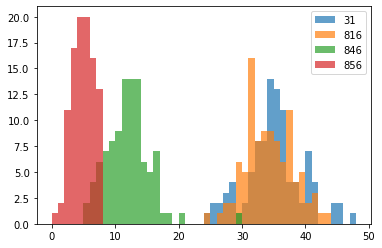

In [22]:
pm, mid = train_model(2000,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 168.53it/s, avg_epoch_loss=1.43]
INFO:root:Epoch[0] Elapsed time 0.595 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.427053
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 168.04it/s, avg_epoch_loss=0.952]
INFO:root:Epoch[1] Elapsed time 0.597 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.952001
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 166.51it/s, avg_epoch_loss=0.659]
INFO:root:Epoch[2] Elapsed time 0.602 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.658649
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 166.97it/s, avg_epoch_loss=0.511]
INFO:root:Epoch[3] Elapsed time 0.601 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.511340
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 164.11it/

100%|██████████| 100/100 [00:00<00:00, 178.24it/s, avg_epoch_loss=0.0866]
INFO:root:Epoch[36] Elapsed time 0.563 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=0.086639
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 175.61it/s, avg_epoch_loss=0.0914]
INFO:root:Epoch[37] Elapsed time 0.571 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.091390
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 175.88it/s, avg_epoch_loss=0.0626]
INFO:root:Epoch[38] Elapsed time 0.570 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.062567
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 177.02it/s, avg_epoch_loss=0.0619]
INFO:root:Epoch[39] Elapsed time 0.566 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.061874
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 179.22it/s, avg_epoch_loss=0.0703]
INFO:root:Epoch[40] Elapsed ti

100%|██████████| 100/100 [00:00<00:00, 178.01it/s, avg_epoch_loss=0.0677]
INFO:root:Epoch[72] Elapsed time 0.563 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.067720
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 174.91it/s, avg_epoch_loss=0.0683]
INFO:root:Epoch[73] Elapsed time 0.573 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.068348
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 177.70it/s, avg_epoch_loss=0.0819]
INFO:root:Epoch[74] Elapsed time 0.565 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.081872
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 175.35it/s, avg_epoch_loss=0.063]
INFO:root:Epoch[75] Elapsed time 0.572 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.062991
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 177.78it/s, avg_epoch_loss=0.0987]
INFO:root:Epoch[76] Ela

INFO:root:Epoch[108] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 179.80it/s, avg_epoch_loss=0.11]
INFO:root:Epoch[108] Elapsed time 0.558 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=0.110125
INFO:root:Epoch[109] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 176.37it/s, avg_epoch_loss=0.0745]
INFO:root:Epoch[109] Elapsed time 0.569 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.074518
INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 177.46it/s, avg_epoch_loss=0.0851]
INFO:root:Epoch[110] Elapsed time 0.565 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.085117
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 176.70it/s, avg_epoch_loss=0.0668]
INFO:root:Epoch[111] Elapsed time 0.568 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.066834
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[143] Evaluation metric 'epoch_loss'=0.069835
INFO:root:Epoch[144] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.82it/s, avg_epoch_loss=0.0848]
INFO:root:Epoch[144] Elapsed time 0.567 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=0.084804
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.60it/s, avg_epoch_loss=0.0718]
INFO:root:Epoch[145] Elapsed time 0.571 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.071785
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.70it/s, avg_epoch_loss=0.0595]
INFO:root:Epoch[146] Elapsed time 0.565 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.059527
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.62it/s, avg_epoch_loss=0.059]
INFO:root:Epoch[147] Elapsed time 0.571 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.058996
INFO:root:Epoch[148] Learning ra

INFO:root:Epoch[180] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 151.82it/s, avg_epoch_loss=0.0862]
INFO:root:Epoch[180] Elapsed time 0.661 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.086174
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.88it/s, avg_epoch_loss=0.0735]
INFO:root:Epoch[181] Elapsed time 0.635 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.073531
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.54it/s, avg_epoch_loss=0.0769]
INFO:root:Epoch[182] Elapsed time 0.553 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.076940
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.50it/s, avg_epoch_loss=0.0855]
INFO:root:Epoch[183] Elapsed time 0.559 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.085525
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.55it/

{
    "MSE": 0.14338395884529645,
    "abs_error": 1039.5928681634666,
    "abs_target_sum": 3083.21469670675,
    "abs_target_mean": 0.8475026653949286,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5329771302418725,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 477.57492457970125,
    "Coverage[0.1]": 0.1858163826278175,
    "QuantileLoss[0.5]": 1039.5928681634666,
    "Coverage[0.5]": 0.5728422210005497,
    "QuantileLoss[0.9]": 593.6251955364994,
    "Coverage[0.9]": 0.820505772402419,
    "RMSE": 0.3786607437341458,
    "NRMSE": 0.4467959325622809,
    "ND": 0.3371782280597841,
    "wQuantileLoss[0.1]": 0.15489512458856972,
    "wQuantileLoss[0.5]": 0.3371782280597841,
    "wQuantileLoss[0.9]": 0.19253449854483493,
    "mean_wQuantileLoss": 0.22820261706439626,
    "MAE_Coverage": 0.07938427707531609
}
idx: 31 t: 31 p: 34
idx: 816 t: 44 p: 33
idx: 846 t: 14 p: 10
idx: 856 t: 4 p: 2


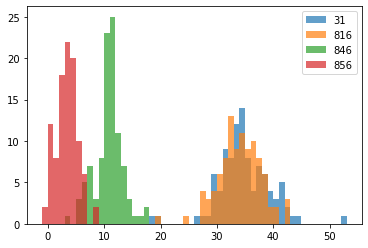

In [23]:
pm, mid = train_model(200,dropout = 0.1, layers=[8,4])
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [20]:
e={}

Running evaluation: 100%|██████████| 3638/3638 [00:20<00:00, 177.03it/s]


{
    "MSE": 0.1699824072874133,
    "abs_error": 1092.8193656709611,
    "abs_target_sum": 3083.21469670675,
    "abs_target_mean": 0.8475026653949286,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5603963980811809,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 482.4253170157214,
    "Coverage[0.1]": 0.13936228697086311,
    "QuantileLoss[0.5]": 1092.8193656709611,
    "Coverage[0.5]": 0.47800989554700385,
    "QuantileLoss[0.9]": 649.2624782002611,
    "Coverage[0.9]": 0.8067619571192963,
    "RMSE": 0.4122892277120678,
    "NRMSE": 0.48647543488249056,
    "ND": 0.35444154013608775,
    "wQuantileLoss[0.1]": 0.156468285368194,
    "wQuantileLoss[0.5]": 0.35444154013608775,
    "wQuantileLoss[0.9]": 0.21057971697324634,
    "mean_wQuantileLoss": 0.24049651415917603,
    "MAE_Coverage": 0.05153014476818765
}
idx: 31 t: 31 p: 31
idx: 816 t: 44 p: 31
idx: 846 t: 14 p: 10
idx: 856 t: 4 p: 3


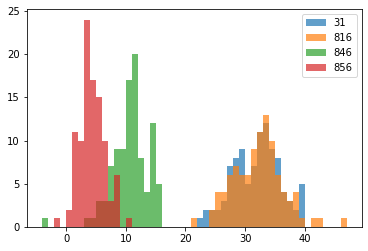

In [21]:
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [220]:
pm, mid = train_model(500, layers=[10,5])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 196.36it/s, avg_epoch_loss=1.22]
INFO:root:Epoch[0] Elapsed time 0.511 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.215777
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 192.51it/s, avg_epoch_loss=0.405]
INFO:root:Epoch[1] Elapsed time 0.521 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.405416
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 166.39it/s, avg_epoch_loss=0.0627]
INFO:root:Epoch[2] Elapsed time 0.602 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.062685
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 196.71it/s, avg_epoch_loss=-.0138]
INFO:root:Epoch[3] Elapsed time 0.510 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.013815
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 197.39

100%|██████████| 100/100 [00:00<00:00, 195.15it/s, avg_epoch_loss=-.109]
INFO:root:Epoch[36] Elapsed time 0.514 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.108623
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 199.92it/s, avg_epoch_loss=-.121]
INFO:root:Epoch[37] Elapsed time 0.502 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.120859
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 199.60it/s, avg_epoch_loss=-.122]
INFO:root:Epoch[38] Elapsed time 0.502 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.121565
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 193.65it/s, avg_epoch_loss=-.122]
INFO:root:Epoch[39] Elapsed time 0.518 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.122051
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 195.68it/s, avg_epoch_loss=-.0931]
INFO:root:Epoch[40] Elapsed ti

100%|██████████| 100/100 [00:00<00:00, 200.15it/s, avg_epoch_loss=-.105]
INFO:root:Epoch[72] Elapsed time 0.501 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-0.104554
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 198.27it/s, avg_epoch_loss=-.127]
INFO:root:Epoch[73] Elapsed time 0.506 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.127186
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 197.96it/s, avg_epoch_loss=-.1]
INFO:root:Epoch[74] Elapsed time 0.507 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.100305
INFO:root:Loading parameters from best epoch (54)
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 197.63it/s, avg_epoch_loss=-.119]
INFO:root:Epoch[75] Elapsed time 0.507 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.118705
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 198.67i

INFO:root:Epoch[107] Evaluation metric 'epoch_loss'=-0.134551
INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.20it/s, avg_epoch_loss=-.102]
INFO:root:Epoch[108] Elapsed time 0.527 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.101836
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.11it/s, avg_epoch_loss=-.115]
INFO:root:Epoch[109] Elapsed time 0.536 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.115406
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.09it/s, avg_epoch_loss=-.129]
INFO:root:Epoch[110] Elapsed time 0.536 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-0.129130
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.49it/s, avg_epoch_loss=-.128]
INFO:root:Epoch[111] Elapsed time 0.529 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.128102
INFO:root:Epoch[112] Learning 

INFO:root:Epoch[144] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.28it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[144] Elapsed time 0.569 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-0.140077
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.00it/s, avg_epoch_loss=-.108]
INFO:root:Epoch[145] Elapsed time 0.563 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.107636
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.19it/s, avg_epoch_loss=-.126]
INFO:root:Epoch[146] Elapsed time 0.580 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-0.126387
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.18it/s, avg_epoch_loss=-.103]
INFO:root:Epoch[147] Elapsed time 0.527 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-0.103117
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.79it/s

100%|██████████| 100/100 [00:00<00:00, 205.17it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[180] Elapsed time 0.489 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=-0.138800
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 207.56it/s, avg_epoch_loss=-.105]
INFO:root:Epoch[181] Elapsed time 0.483 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.105065
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 204.21it/s, avg_epoch_loss=-.112]
INFO:root:Epoch[182] Elapsed time 0.491 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.111730
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 209.53it/s, avg_epoch_loss=-.131]
INFO:root:Epoch[183] Elapsed time 0.479 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-0.131185
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 207.15it/s, avg_epoch_loss=-.129]
INFO:root:Epoch[184

100%|██████████| 100/100 [00:00<00:00, 189.11it/s, avg_epoch_loss=-.124]
INFO:root:Epoch[216] Elapsed time 0.531 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=-0.123764
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 182.11it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[217] Elapsed time 0.551 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-0.138814
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.41it/s, avg_epoch_loss=-.11]
INFO:root:Epoch[218] Elapsed time 0.529 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-0.109925
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.09it/s, avg_epoch_loss=-.124]
INFO:root:Epoch[219] Elapsed time 0.533 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-0.123977
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.17it/s, avg_epoch_loss=-.108]
INFO:root:Epoch[220]

100%|██████████| 100/100 [00:00<00:00, 186.32it/s, avg_epoch_loss=-.11]
INFO:root:Epoch[252] Elapsed time 0.538 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-0.109518
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.10it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[253] Elapsed time 0.536 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.139240
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.38it/s, avg_epoch_loss=-.107]
INFO:root:Epoch[254] Elapsed time 0.535 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.107293
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.73it/s, avg_epoch_loss=-.114]
INFO:root:Epoch[255] Elapsed time 0.543 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-0.114403
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.85it/s, avg_epoch_loss=-.132]
INFO:root:Epoch[256]

100%|██████████| 100/100 [00:00<00:00, 192.30it/s, avg_epoch_loss=-.121]
INFO:root:Epoch[288] Elapsed time 0.521 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=-0.121051
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 195.01it/s, avg_epoch_loss=-.122]
INFO:root:Epoch[289] Elapsed time 0.514 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-0.122384
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 192.05it/s, avg_epoch_loss=-.144]
INFO:root:Epoch[290] Elapsed time 0.522 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-0.143885
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 193.55it/s, avg_epoch_loss=-.111]
INFO:root:Epoch[291] Elapsed time 0.518 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-0.111064
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 196.23it/s, avg_epoch_loss=-.123]
INFO:root:Epoch[292

100%|██████████| 100/100 [00:00<00:00, 195.47it/s, avg_epoch_loss=-.126]
INFO:root:Epoch[324] Elapsed time 0.513 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=-0.125644
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 192.08it/s, avg_epoch_loss=-.111]
INFO:root:Epoch[325] Elapsed time 0.522 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-0.111029
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 192.60it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[326] Elapsed time 0.521 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-0.140301
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 195.81it/s, avg_epoch_loss=-.108]
INFO:root:Epoch[327] Elapsed time 0.512 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-0.108004
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 198.81it/s, avg_epoch_loss=-.116]
INFO:root:Epoch[328]

100%|██████████| 100/100 [00:00<00:00, 197.00it/s, avg_epoch_loss=-.109]
INFO:root:Epoch[360] Elapsed time 0.509 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=-0.108526
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 196.25it/s, avg_epoch_loss=-.123]
INFO:root:Epoch[361] Elapsed time 0.511 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-0.123454
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.57it/s, avg_epoch_loss=-.127]
INFO:root:Epoch[362] Elapsed time 0.562 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-0.127094
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.17it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[363] Elapsed time 0.548 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-0.141456
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.84it/s, avg_epoch_loss=-.112]
INFO:root:Epoch[364

100%|██████████| 100/100 [00:00<00:00, 181.27it/s, avg_epoch_loss=-.133]
INFO:root:Epoch[396] Elapsed time 0.553 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=-0.133052
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.92it/s, avg_epoch_loss=-.126]
INFO:root:Epoch[397] Elapsed time 0.647 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-0.126193
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.03it/s, avg_epoch_loss=-.112]
INFO:root:Epoch[398] Elapsed time 0.596 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.111709
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.13it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[399] Elapsed time 0.554 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-0.141110
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 193.25it/s, avg_epoch_loss=-.109]
INFO:root:Epoch[400

100%|██████████| 100/100 [00:00<00:00, 209.07it/s, avg_epoch_loss=-.129]
INFO:root:Epoch[432] Elapsed time 0.480 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=-0.129238
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 202.95it/s, avg_epoch_loss=-.11]
INFO:root:Epoch[433] Elapsed time 0.494 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-0.109808
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 202.47it/s, avg_epoch_loss=-.124]
INFO:root:Epoch[434] Elapsed time 0.495 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-0.123562
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 199.25it/s, avg_epoch_loss=-.127]
INFO:root:Epoch[435] Elapsed time 0.503 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-0.127392
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 207.88it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[436]

100%|██████████| 100/100 [00:00<00:00, 210.04it/s, avg_epoch_loss=-.124]
INFO:root:Epoch[468] Elapsed time 0.477 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=-0.123678
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 203.81it/s, avg_epoch_loss=-.132]
INFO:root:Epoch[469] Elapsed time 0.492 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-0.131847
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 205.16it/s, avg_epoch_loss=-.129]
INFO:root:Epoch[470] Elapsed time 0.489 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-0.129257
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 205.08it/s, avg_epoch_loss=-.113]
INFO:root:Epoch[471] Elapsed time 0.489 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-0.113152
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 204.11it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[472

{
    "MSE": 0.3086568233792749,
    "abs_error": 1585.2765641315914,
    "abs_target_sum": 3677.5622829723397,
    "abs_target_mean": 1.0108747341870092,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6669529076483897,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 603.7919668483962,
    "Coverage[0.1]": 0.049752611324903794,
    "QuantileLoss[0.5]": 1585.2765641315914,
    "Coverage[0.5]": 0.13551401869158877,
    "QuantileLoss[0.9]": 1493.2853354795673,
    "Coverage[0.9]": 0.3633864760857614,
    "RMSE": 0.55556891865841,
    "NRMSE": 0.5495922490388716,
    "ND": 0.4310672239248422,
    "wQuantileLoss[0.1]": 0.16418266242397656,
    "wQuantileLoss[0.5]": 0.4310672239248422,
    "wQuantileLoss[0.9]": 0.40605303746824367,
    "mean_wQuantileLoss": 0.3337676412723541,
    "MAE_Coverage": 0.3171156312992487
}


In [221]:
pm, mid = train_model(500, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 160.67it/s, avg_epoch_loss=0.726]
INFO:root:Epoch[0] Elapsed time 0.624 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.725802
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 164.55it/s, avg_epoch_loss=0.00447]
INFO:root:Epoch[1] Elapsed time 0.609 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.004470
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 166.78it/s, avg_epoch_loss=-.0506]
INFO:root:Epoch[2] Elapsed time 0.601 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.050599
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 170.83it/s, avg_epoch_loss=-.0707]
INFO:root:Epoch[3] Elapsed time 0.587 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.070750
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 16

100%|██████████| 100/100 [00:00<00:00, 153.30it/s, avg_epoch_loss=-.137]
INFO:root:Epoch[36] Elapsed time 0.654 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.136878
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 157.84it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[37] Elapsed time 0.635 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.148723
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 157.86it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[38] Elapsed time 0.635 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.141253
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 158.23it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[39] Elapsed time 0.634 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.154900
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 126.93it/s, avg_epoch_loss=-.121]
INFO:root:Epoch[40] Elapsed tim

100%|██████████| 100/100 [00:00<00:00, 147.41it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[72] Elapsed time 0.681 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-0.138561
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 175.69it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[73] Elapsed time 0.571 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.160194
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 176.00it/s, avg_epoch_loss=-.136]
INFO:root:Epoch[74] Elapsed time 0.569 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.135762
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 174.13it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[75] Elapsed time 0.576 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.155547
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 173.47it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[76] Elap

INFO:root:Epoch[107] Evaluation metric 'epoch_loss'=-0.173011
INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 151.17it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[108] Elapsed time 0.663 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.143384
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 146.96it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[109] Elapsed time 0.682 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.155437
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 144.58it/s, avg_epoch_loss=-.163]
INFO:root:Epoch[110] Elapsed time 0.693 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-0.163237
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.08it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[111] Elapsed time 0.681 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.164873
INFO:root:Epoch[112] Learning 

INFO:root:Epoch[144] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.06it/s, avg_epoch_loss=-.175]
INFO:root:Epoch[144] Elapsed time 0.611 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-0.175020
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.86it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[145] Elapsed time 0.597 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.145581
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.42it/s, avg_epoch_loss=-.161]
INFO:root:Epoch[146] Elapsed time 0.610 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-0.161470
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.65it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[147] Elapsed time 0.616 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-0.142723
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.98it/

100%|██████████| 100/100 [00:00<00:00, 174.75it/s, avg_epoch_loss=-.177]
INFO:root:Epoch[180] Elapsed time 0.574 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=-0.176804
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.10it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[181] Elapsed time 0.572 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.147252
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.22it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[182] Elapsed time 0.578 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.151850
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.58it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[183] Elapsed time 0.577 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-0.165696
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.69it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[184

100%|██████████| 100/100 [00:00<00:00, 165.62it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[216] Elapsed time 0.605 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=-0.166183
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.67it/s, avg_epoch_loss=-.175]
INFO:root:Epoch[217] Elapsed time 0.624 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-0.174758
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 142.54it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[218] Elapsed time 0.703 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-0.148884
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 139.13it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[219] Elapsed time 0.720 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-0.157912
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.65it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[220

100%|██████████| 100/100 [00:00<00:00, 170.27it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[252] Elapsed time 0.589 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-0.145553
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.31it/s, avg_epoch_loss=-.178]
INFO:root:Epoch[253] Elapsed time 0.603 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.177522
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.25it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[254] Elapsed time 0.575 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.148904
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.17it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[255] Elapsed time 0.582 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-0.154066
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.41it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[256

100%|██████████| 100/100 [00:00<00:00, 154.45it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[288] Elapsed time 0.649 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=-0.159071
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.34it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[289] Elapsed time 0.671 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-0.165467
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 142.85it/s, avg_epoch_loss=-.179]
INFO:root:Epoch[290] Elapsed time 0.702 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-0.179472
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 144.75it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[291] Elapsed time 0.693 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-0.150026
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 144.21it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[292]

100%|██████████| 100/100 [00:00<00:00, 175.39it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[324] Elapsed time 0.571 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=-0.161508
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.99it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[325] Elapsed time 0.570 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-0.147994
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.24it/s, avg_epoch_loss=-.179]
INFO:root:Epoch[326] Elapsed time 0.565 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-0.179328
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.32it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[327] Elapsed time 0.582 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-0.148606
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.53it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[328

100%|██████████| 100/100 [00:00<00:00, 166.29it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[360] Elapsed time 0.603 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=-0.145826
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.73it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[361] Elapsed time 0.609 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-0.162190
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.75it/s, avg_epoch_loss=-.169]
INFO:root:Epoch[362] Elapsed time 0.616 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-0.168816
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.53it/s, avg_epoch_loss=-.177]
INFO:root:Epoch[363] Elapsed time 0.602 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-0.177240
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.36it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[364

100%|██████████| 100/100 [00:00<00:00, 155.44it/s, avg_epoch_loss=-.172]
INFO:root:Epoch[396] Elapsed time 0.645 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=-0.171594
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.93it/s, avg_epoch_loss=-.163]
INFO:root:Epoch[397] Elapsed time 0.611 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-0.163440
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.42it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[398] Elapsed time 0.613 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.149108
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.82it/s, avg_epoch_loss=-.179]
INFO:root:Epoch[399] Elapsed time 0.612 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-0.179186
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.35it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[400

100%|██████████| 100/100 [00:00<00:00, 170.37it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[432] Elapsed time 0.588 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=-0.166707
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.92it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[433] Elapsed time 0.608 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-0.146690
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.86it/s, avg_epoch_loss=-.161]
INFO:root:Epoch[434] Elapsed time 0.604 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-0.161174
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.25it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[435] Elapsed time 0.603 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-0.169871
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.51it/s, avg_epoch_loss=-.178]
INFO:root:Epoch[436]

100%|██████████| 100/100 [00:00<00:00, 154.76it/s, avg_epoch_loss=-.163]
INFO:root:Epoch[468] Elapsed time 0.648 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=-0.163091
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.24it/s, avg_epoch_loss=-.171]
INFO:root:Epoch[469] Elapsed time 0.638 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-0.170660
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.22it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[470] Elapsed time 0.630 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-0.166068
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.88it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[471] Elapsed time 0.639 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-0.150666
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.99it/s, avg_epoch_loss=-.181]
INFO:root:Epoch[472

{
    "MSE": 0.2981205094327549,
    "abs_error": 1540.1938594877683,
    "abs_target_sum": 3677.5622829723397,
    "abs_target_mean": 1.0108747341870092,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6685573749687055,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 613.0507080137261,
    "Coverage[0.1]": 0.06926882902693787,
    "QuantileLoss[0.5]": 1540.1938594877683,
    "Coverage[0.5]": 0.15228147333699835,
    "QuantileLoss[0.9]": 1455.6545566663103,
    "Coverage[0.9]": 0.38235294117647056,
    "RMSE": 0.5460041295015587,
    "NRMSE": 0.5401303554596008,
    "ND": 0.4188083684181489,
    "wQuantileLoss[0.1]": 0.166700292433453,
    "wQuantileLoss[0.5]": 0.4188083684181489,
    "wQuantileLoss[0.9]": 0.3958205040894093,
    "mean_wQuantileLoss": 0.32710972164700375,
    "MAE_Coverage": 0.2986989188198644
}


idx: 31 t: 31 p: 30
idx: 816 t: 44 p: 30
idx: 846 t: 14 p: 9
idx: 856 t: 4 p: 0


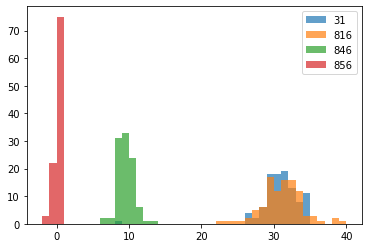

In [222]:
run_test(t[mid], s[mid], [31,816,846,856])

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 151.69it/s, avg_epoch_loss=0.744]
INFO:root:Epoch[0] Elapsed time 0.661 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.744444
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 155.05it/s, avg_epoch_loss=-.0131]
INFO:root:Epoch[1] Elapsed time 0.647 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.013148
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 160.36it/s, avg_epoch_loss=-.0564]
INFO:root:Epoch[2] Elapsed time 0.625 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.056399
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 164.27it/s, avg_epoch_loss=-.0788]
INFO:root:Epoch[3] Elapsed time 0.611 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.078842
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 16

100%|██████████| 100/100 [00:00<00:00, 129.19it/s, avg_epoch_loss=-.118]
INFO:root:Epoch[36] Elapsed time 0.776 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.118323
INFO:root:Loading parameters from best epoch (26)
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 122.46it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[37] Elapsed time 0.819 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.146161
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 132.64it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[38] Elapsed time 0.756 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.141033
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 132.84it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[39] Elapsed time 0.755 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.143484
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 138.84it/s,

INFO:root:Epoch[72] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 139.77it/s, avg_epoch_loss=-.127]
INFO:root:Epoch[72] Elapsed time 0.717 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-0.126734
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 149.63it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[73] Elapsed time 0.671 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.150051
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 144.19it/s, avg_epoch_loss=-.125]
INFO:root:Epoch[74] Elapsed time 0.696 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.125077
INFO:root:Loading parameters from best epoch (54)
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 137.50it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[75] Elapsed time 0.729 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.146120
INFO:root:Epoch[76] Learning rate is 6.25e-

INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.37it/s, avg_epoch_loss=-.13]
INFO:root:Epoch[108] Elapsed time 0.614 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.130010
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.89it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[109] Elapsed time 0.620 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.141545
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.76it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[110] Elapsed time 0.610 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-0.156631
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.81it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[111] Elapsed time 0.609 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.151004
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.58it/s

100%|██████████| 100/100 [00:00<00:00, 163.44it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[144] Elapsed time 0.613 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-0.165842
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.92it/s, avg_epoch_loss=-.132]
INFO:root:Epoch[145] Elapsed time 0.627 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.131967
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.64it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[146] Elapsed time 0.644 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-0.149525
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.57it/s, avg_epoch_loss=-.129]
INFO:root:Epoch[147] Elapsed time 0.628 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-0.129244
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.49it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[148] 

100%|██████████| 100/100 [00:00<00:00, 163.09it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[180] Elapsed time 0.615 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=-0.166041
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.53it/s, avg_epoch_loss=-.134]
INFO:root:Epoch[181] Elapsed time 0.613 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.133605
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.80it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[182] Elapsed time 0.616 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.138629
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.42it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[183] Elapsed time 0.625 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-0.158395
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.43it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[184

100%|██████████| 100/100 [00:00<00:00, 164.53it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[216] Elapsed time 0.609 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=-0.154728
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.80it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[217] Elapsed time 0.612 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-0.165132
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.88it/s, avg_epoch_loss=-.135]
INFO:root:Epoch[218] Elapsed time 0.619 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-0.134682
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.97it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[219] Elapsed time 0.627 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-0.146814
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.90it/s, avg_epoch_loss=-.135]
INFO:root:Epoch[220

100%|██████████| 100/100 [00:00<00:00, 154.99it/s, avg_epoch_loss=-.132]
INFO:root:Epoch[252] Elapsed time 0.647 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-0.131871
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 153.96it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[253] Elapsed time 0.651 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.166667
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 150.45it/s, avg_epoch_loss=-.135]
INFO:root:Epoch[254] Elapsed time 0.666 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.134654
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 150.92it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[255] Elapsed time 0.664 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-0.141597
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.38it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[256

100%|██████████| 100/100 [00:00<00:00, 169.58it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[288] Elapsed time 0.591 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=-0.146738
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.64it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[289] Elapsed time 0.602 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-0.154149
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.84it/s, avg_epoch_loss=-.169]
INFO:root:Epoch[290] Elapsed time 0.587 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-0.168930
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 142.97it/s, avg_epoch_loss=-.136]
INFO:root:Epoch[291] Elapsed time 0.701 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-0.135642
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.59it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[292

100%|██████████| 100/100 [00:00<00:00, 167.03it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[324] Elapsed time 0.600 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=-0.151835
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.05it/s, avg_epoch_loss=-.134]
INFO:root:Epoch[325] Elapsed time 0.611 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-0.133956
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.54it/s, avg_epoch_loss=-.168]
INFO:root:Epoch[326] Elapsed time 0.599 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-0.168244
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.68it/s, avg_epoch_loss=-.136]
INFO:root:Epoch[327] Elapsed time 0.601 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-0.135596
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.18it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[328

100%|██████████| 100/100 [00:00<00:00, 134.73it/s, avg_epoch_loss=-.134]
INFO:root:Epoch[360] Elapsed time 0.744 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=-0.134442
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 134.79it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[361] Elapsed time 0.744 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-0.148676
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 143.40it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[362] Elapsed time 0.699 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-0.158555
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.81it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[363] Elapsed time 0.619 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-0.166175
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.99it/s, avg_epoch_loss=-.137]
INFO:root:Epoch[364

100%|██████████| 100/100 [00:00<00:00, 160.02it/s, avg_epoch_loss=-.161]
INFO:root:Epoch[396] Elapsed time 0.627 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=-0.160562
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.55it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[397] Elapsed time 0.617 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-0.152705
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.73it/s, avg_epoch_loss=-.135]
INFO:root:Epoch[398] Elapsed time 0.616 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.134617
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.83it/s, avg_epoch_loss=-.168]
INFO:root:Epoch[399] Elapsed time 0.616 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-0.168056
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.74it/s, avg_epoch_loss=-.136]
INFO:root:Epoch[400

100%|██████████| 100/100 [00:00<00:00, 162.95it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[432] Elapsed time 0.615 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=-0.152699
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.79it/s, avg_epoch_loss=-.135]
INFO:root:Epoch[433] Elapsed time 0.616 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-0.134671
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.93it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[434] Elapsed time 0.615 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-0.148142
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.96it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[435] Elapsed time 0.611 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-0.159528
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.49it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[436]

100%|██████████| 100/100 [00:00<00:00, 159.97it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[468] Elapsed time 0.627 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=-0.150218
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.91it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[469] Elapsed time 0.627 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-0.159055
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.33it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[470] Elapsed time 0.633 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-0.155253
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.68it/s, avg_epoch_loss=-.137]
INFO:root:Epoch[471] Elapsed time 0.636 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-0.136662
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.35it/s, avg_epoch_loss=-.169]
INFO:root:Epoch[472]

100%|██████████| 100/100 [00:00<00:00, 167.76it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[504] Elapsed time 0.597 seconds
INFO:root:Epoch[504] Evaluation metric 'epoch_loss'=-0.161754
INFO:root:Epoch[505] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.77it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[505] Elapsed time 0.584 seconds
INFO:root:Epoch[505] Evaluation metric 'epoch_loss'=-0.153464
INFO:root:Epoch[506] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.36it/s, avg_epoch_loss=-.135]
INFO:root:Epoch[506] Elapsed time 0.599 seconds
INFO:root:Epoch[506] Evaluation metric 'epoch_loss'=-0.135222
INFO:root:Epoch[507] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.19it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[507] Elapsed time 0.600 seconds
INFO:root:Epoch[507] Evaluation metric 'epoch_loss'=-0.150394
INFO:root:Epoch[508] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.50it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[508]

100%|██████████| 100/100 [00:00<00:00, 171.26it/s, avg_epoch_loss=-.138]
INFO:root:Epoch[540] Elapsed time 0.585 seconds
INFO:root:Epoch[540] Evaluation metric 'epoch_loss'=-0.137726
INFO:root:Epoch[541] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.32it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[541] Elapsed time 0.582 seconds
INFO:root:Epoch[541] Evaluation metric 'epoch_loss'=-0.152752
INFO:root:Epoch[542] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.12it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[542] Elapsed time 0.593 seconds
INFO:root:Epoch[542] Evaluation metric 'epoch_loss'=-0.159751
INFO:root:Epoch[543] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.51it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[543] Elapsed time 0.595 seconds
INFO:root:Epoch[543] Evaluation metric 'epoch_loss'=-0.154897
INFO:root:Epoch[544] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.02it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[544] 

100%|██████████| 100/100 [00:00<00:00, 162.52it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[576] Elapsed time 0.617 seconds
INFO:root:Epoch[576] Evaluation metric 'epoch_loss'=-0.155931
INFO:root:Epoch[577] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.57it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[577] Elapsed time 0.620 seconds
INFO:root:Epoch[577] Evaluation metric 'epoch_loss'=-0.162395
INFO:root:Epoch[578] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.03it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[578] Elapsed time 0.623 seconds
INFO:root:Epoch[578] Evaluation metric 'epoch_loss'=-0.155987
INFO:root:Epoch[579] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.80it/s, avg_epoch_loss=-.133]
INFO:root:Epoch[579] Elapsed time 0.608 seconds
INFO:root:Epoch[579] Evaluation metric 'epoch_loss'=-0.133352
INFO:root:Epoch[580] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.22it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[580]

100%|██████████| 100/100 [00:00<00:00, 169.32it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[612] Elapsed time 0.592 seconds
INFO:root:Epoch[612] Evaluation metric 'epoch_loss'=-0.153951
INFO:root:Epoch[613] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.70it/s, avg_epoch_loss=-.138]
INFO:root:Epoch[613] Elapsed time 0.602 seconds
INFO:root:Epoch[613] Evaluation metric 'epoch_loss'=-0.138384
INFO:root:Epoch[614] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.26it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[614] Elapsed time 0.596 seconds
INFO:root:Epoch[614] Evaluation metric 'epoch_loss'=-0.154725
INFO:root:Epoch[615] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.48it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[615] Elapsed time 0.606 seconds
INFO:root:Epoch[615] Evaluation metric 'epoch_loss'=-0.159145
INFO:root:Epoch[616] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.30it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[616

100%|██████████| 100/100 [00:00<00:00, 162.73it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[648] Elapsed time 0.617 seconds
INFO:root:Epoch[648] Evaluation metric 'epoch_loss'=-0.149649
INFO:root:Epoch[649] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.33it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[649] Elapsed time 0.614 seconds
INFO:root:Epoch[649] Evaluation metric 'epoch_loss'=-0.161672
INFO:root:Epoch[650] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.21it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[650] Elapsed time 0.614 seconds
INFO:root:Epoch[650] Evaluation metric 'epoch_loss'=-0.156486
INFO:root:Epoch[651] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.95it/s, avg_epoch_loss=-.164]
INFO:root:Epoch[651] Elapsed time 0.615 seconds
INFO:root:Epoch[651] Evaluation metric 'epoch_loss'=-0.163884
INFO:root:Epoch[652] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.56it/s, avg_epoch_loss=-.131]
INFO:root:Epoch[652]

100%|██████████| 100/100 [00:00<00:00, 165.06it/s, avg_epoch_loss=-.136]
INFO:root:Epoch[684] Elapsed time 0.607 seconds
INFO:root:Epoch[684] Evaluation metric 'epoch_loss'=-0.135604
INFO:root:Epoch[685] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.04it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[685] Elapsed time 0.604 seconds
INFO:root:Epoch[685] Evaluation metric 'epoch_loss'=-0.157097
INFO:root:Epoch[686] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.81it/s, avg_epoch_loss=-.134]
INFO:root:Epoch[686] Elapsed time 0.608 seconds
INFO:root:Epoch[686] Evaluation metric 'epoch_loss'=-0.133764
INFO:root:Epoch[687] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.16it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[687] Elapsed time 0.611 seconds
INFO:root:Epoch[687] Evaluation metric 'epoch_loss'=-0.156879
INFO:root:Epoch[688] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.91it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[688

100%|██████████| 100/100 [00:00<00:00, 167.74it/s, avg_epoch_loss=-.138]
INFO:root:Epoch[720] Elapsed time 0.598 seconds
INFO:root:Epoch[720] Evaluation metric 'epoch_loss'=-0.137696
INFO:root:Epoch[721] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.65it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[721] Elapsed time 0.601 seconds
INFO:root:Epoch[721] Evaluation metric 'epoch_loss'=-0.150797
INFO:root:Epoch[722] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.72it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[722] Elapsed time 0.605 seconds
INFO:root:Epoch[722] Evaluation metric 'epoch_loss'=-0.160288
INFO:root:Epoch[723] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.57it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[723] Elapsed time 0.605 seconds
INFO:root:Epoch[723] Evaluation metric 'epoch_loss'=-0.157341
INFO:root:Epoch[724] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.67it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[724]

100%|██████████| 100/100 [00:00<00:00, 171.45it/s, avg_epoch_loss=-.171]
INFO:root:Epoch[756] Elapsed time 0.584 seconds
INFO:root:Epoch[756] Evaluation metric 'epoch_loss'=-0.171311
INFO:root:Epoch[757] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.08it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[757] Elapsed time 0.590 seconds
INFO:root:Epoch[757] Evaluation metric 'epoch_loss'=-0.138533
INFO:root:Epoch[758] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.81it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[758] Elapsed time 0.597 seconds
INFO:root:Epoch[758] Evaluation metric 'epoch_loss'=-0.154878
INFO:root:Epoch[759] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.39it/s, avg_epoch_loss=-.136]
INFO:root:Epoch[759] Elapsed time 0.595 seconds
INFO:root:Epoch[759] Evaluation metric 'epoch_loss'=-0.136271
INFO:root:Epoch[760] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.53it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[760

100%|██████████| 100/100 [00:00<00:00, 148.69it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[792] Elapsed time 0.674 seconds
INFO:root:Epoch[792] Evaluation metric 'epoch_loss'=-0.169609
INFO:root:Epoch[793] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.30it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[793] Elapsed time 0.650 seconds
INFO:root:Epoch[793] Evaluation metric 'epoch_loss'=-0.140594
INFO:root:Epoch[794] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.85it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[794] Elapsed time 0.643 seconds
INFO:root:Epoch[794] Evaluation metric 'epoch_loss'=-0.145628
INFO:root:Epoch[795] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.35it/s, avg_epoch_loss=-.163]
INFO:root:Epoch[795] Elapsed time 0.637 seconds
INFO:root:Epoch[795] Evaluation metric 'epoch_loss'=-0.162753
INFO:root:Epoch[796] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.88it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[796] 

100%|██████████| 100/100 [00:00<00:00, 180.27it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[828] Elapsed time 0.556 seconds
INFO:root:Epoch[828] Evaluation metric 'epoch_loss'=-0.162292
INFO:root:Epoch[829] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.52it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[829] Elapsed time 0.561 seconds
INFO:root:Epoch[829] Evaluation metric 'epoch_loss'=-0.170142
INFO:root:Epoch[830] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.17it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[830] Elapsed time 0.596 seconds
INFO:root:Epoch[830] Evaluation metric 'epoch_loss'=-0.140459
INFO:root:Epoch[831] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.47it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[831] Elapsed time 0.595 seconds
INFO:root:Epoch[831] Evaluation metric 'epoch_loss'=-0.151926
INFO:root:Epoch[832] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.00it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[832] 

100%|██████████| 100/100 [00:00<00:00, 171.02it/s, avg_epoch_loss=-.136]
INFO:root:Epoch[864] Elapsed time 0.586 seconds
INFO:root:Epoch[864] Evaluation metric 'epoch_loss'=-0.136159
INFO:root:Epoch[865] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.79it/s, avg_epoch_loss=-.172]
INFO:root:Epoch[865] Elapsed time 0.591 seconds
INFO:root:Epoch[865] Evaluation metric 'epoch_loss'=-0.172061
INFO:root:Epoch[866] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.94it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[866] Elapsed time 0.587 seconds
INFO:root:Epoch[866] Evaluation metric 'epoch_loss'=-0.140270
INFO:root:Epoch[867] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.64it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[867] Elapsed time 0.587 seconds
INFO:root:Epoch[867] Evaluation metric 'epoch_loss'=-0.149294
INFO:root:Epoch[868] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.26it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[868]

100%|██████████| 100/100 [00:00<00:00, 175.76it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[900] Elapsed time 0.570 seconds
INFO:root:Epoch[900] Evaluation metric 'epoch_loss'=-0.152233
INFO:root:Epoch[901] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.22it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[901] Elapsed time 0.565 seconds
INFO:root:Epoch[901] Evaluation metric 'epoch_loss'=-0.161840
INFO:root:Epoch[902] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.70it/s, avg_epoch_loss=-.172]
INFO:root:Epoch[902] Elapsed time 0.564 seconds
INFO:root:Epoch[902] Evaluation metric 'epoch_loss'=-0.171587
INFO:root:Epoch[903] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.15it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[903] Elapsed time 0.566 seconds
INFO:root:Epoch[903] Evaluation metric 'epoch_loss'=-0.142011
INFO:root:Epoch[904] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.52it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[904

100%|██████████| 100/100 [00:00<00:00, 177.94it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[936] Elapsed time 0.563 seconds
INFO:root:Epoch[936] Evaluation metric 'epoch_loss'=-0.156283
INFO:root:Epoch[937] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.87it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[937] Elapsed time 0.587 seconds
INFO:root:Epoch[937] Evaluation metric 'epoch_loss'=-0.140557
INFO:root:Epoch[938] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.92it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[938] Elapsed time 0.580 seconds
INFO:root:Epoch[938] Evaluation metric 'epoch_loss'=-0.170458
INFO:root:Epoch[939] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.54it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[939] Elapsed time 0.644 seconds
INFO:root:Epoch[939] Evaluation metric 'epoch_loss'=-0.141963
INFO:root:Epoch[940] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.16it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[940]

100%|██████████| 100/100 [00:00<00:00, 178.76it/s, avg_epoch_loss=-.138]
INFO:root:Epoch[972] Elapsed time 0.561 seconds
INFO:root:Epoch[972] Evaluation metric 'epoch_loss'=-0.137923
INFO:root:Epoch[973] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.62it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[973] Elapsed time 0.558 seconds
INFO:root:Epoch[973] Evaluation metric 'epoch_loss'=-0.154144
INFO:root:Epoch[974] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.99it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[974] Elapsed time 0.554 seconds
INFO:root:Epoch[974] Evaluation metric 'epoch_loss'=-0.164800
INFO:root:Epoch[975] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.89it/s, avg_epoch_loss=-.172]
INFO:root:Epoch[975] Elapsed time 0.560 seconds
INFO:root:Epoch[975] Evaluation metric 'epoch_loss'=-0.171750
INFO:root:Epoch[976] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.38it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[976

100%|██████████| 100/100 [00:00<00:00, 179.04it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[1008] Elapsed time 0.560 seconds
INFO:root:Epoch[1008] Evaluation metric 'epoch_loss'=-0.165152
INFO:root:Epoch[1009] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.53it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[1009] Elapsed time 0.561 seconds
INFO:root:Epoch[1009] Evaluation metric 'epoch_loss'=-0.157558
INFO:root:Epoch[1010] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.40it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[1010] Elapsed time 0.588 seconds
INFO:root:Epoch[1010] Evaluation metric 'epoch_loss'=-0.140213
INFO:root:Epoch[1011] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.28it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[1011] Elapsed time 0.575 seconds
INFO:root:Epoch[1011] Evaluation metric 'epoch_loss'=-0.170331
INFO:root:Epoch[1012] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.83it/s, avg_epoch_loss=-.143]
INFO:root

INFO:root:Epoch[1044] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.58it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[1044] Elapsed time 0.568 seconds
INFO:root:Epoch[1044] Evaluation metric 'epoch_loss'=-0.158291
INFO:root:Epoch[1045] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.50it/s, avg_epoch_loss=-.138]
INFO:root:Epoch[1045] Elapsed time 0.571 seconds
INFO:root:Epoch[1045] Evaluation metric 'epoch_loss'=-0.137770
INFO:root:Epoch[1046] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.42it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[1046] Elapsed time 0.565 seconds
INFO:root:Epoch[1046] Evaluation metric 'epoch_loss'=-0.153090
INFO:root:Epoch[1047] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.60it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[1047] Elapsed time 0.571 seconds
INFO:root:Epoch[1047] Evaluation metric 'epoch_loss'=-0.164509
INFO:root:Epoch[1048] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1079] Evaluation metric 'epoch_loss'=-0.143864
INFO:root:Epoch[1080] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.73it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[1080] Elapsed time 0.570 seconds
INFO:root:Epoch[1080] Evaluation metric 'epoch_loss'=-0.153315
INFO:root:Epoch[1081] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.36it/s, avg_epoch_loss=-.164]
INFO:root:Epoch[1081] Elapsed time 0.565 seconds
INFO:root:Epoch[1081] Evaluation metric 'epoch_loss'=-0.163532
INFO:root:Epoch[1082] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.29it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[1082] Elapsed time 0.559 seconds
INFO:root:Epoch[1082] Evaluation metric 'epoch_loss'=-0.159926
INFO:root:Epoch[1083] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.65it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[1083] Elapsed time 0.558 seconds
INFO:root:Epoch[1083] Evaluation metric 'epoch_loss'=-0.141406
INFO:root:Epoch[10

100%|██████████| 100/100 [00:00<00:00, 169.30it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[1115] Elapsed time 0.592 seconds
INFO:root:Epoch[1115] Evaluation metric 'epoch_loss'=-0.160268
INFO:root:Epoch[1116] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.65it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[1116] Elapsed time 0.577 seconds
INFO:root:Epoch[1116] Evaluation metric 'epoch_loss'=-0.165950
INFO:root:Epoch[1117] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.41it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[1117] Elapsed time 0.585 seconds
INFO:root:Epoch[1117] Evaluation metric 'epoch_loss'=-0.157091
INFO:root:Epoch[1118] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.49it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[1118] Elapsed time 0.565 seconds
INFO:root:Epoch[1118] Evaluation metric 'epoch_loss'=-0.138845
INFO:root:Epoch[1119] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.78it/s, avg_epoch_loss=-.156]
INFO:roo

INFO:root:Epoch[1151] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.42it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[1151] Elapsed time 0.565 seconds
INFO:root:Epoch[1151] Evaluation metric 'epoch_loss'=-0.154298
INFO:root:Epoch[1152] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.55it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[1152] Elapsed time 0.568 seconds
INFO:root:Epoch[1152] Evaluation metric 'epoch_loss'=-0.141611
INFO:root:Epoch[1153] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.78it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[1153] Elapsed time 0.567 seconds
INFO:root:Epoch[1153] Evaluation metric 'epoch_loss'=-0.157516
INFO:root:Epoch[1154] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.57it/s, avg_epoch_loss=-.164]
INFO:root:Epoch[1154] Elapsed time 0.564 seconds
INFO:root:Epoch[1154] Evaluation metric 'epoch_loss'=-0.164316
INFO:root:Epoch[1155] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1186] Evaluation metric 'epoch_loss'=-0.143167
INFO:root:Epoch[1187] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.19it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[1187] Elapsed time 0.607 seconds
INFO:root:Epoch[1187] Evaluation metric 'epoch_loss'=-0.155680
INFO:root:Epoch[1188] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.43it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1188] Elapsed time 0.610 seconds
INFO:root:Epoch[1188] Evaluation metric 'epoch_loss'=-0.159061
INFO:root:Epoch[1189] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.67it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[1189] Elapsed time 0.602 seconds
INFO:root:Epoch[1189] Evaluation metric 'epoch_loss'=-0.167089
INFO:root:Epoch[1190] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.96it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1190] Elapsed time 0.600 seconds
INFO:root:Epoch[1190] Evaluation metric 'epoch_loss'=-0.159254
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 176.43it/s, avg_epoch_loss=-.174]
INFO:root:Epoch[1222] Elapsed time 0.568 seconds
INFO:root:Epoch[1222] Evaluation metric 'epoch_loss'=-0.173726
INFO:root:Epoch[1223] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.16it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[1223] Elapsed time 0.569 seconds
INFO:root:Epoch[1223] Evaluation metric 'epoch_loss'=-0.140682
INFO:root:Epoch[1224] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.02it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[1224] Elapsed time 0.573 seconds
INFO:root:Epoch[1224] Evaluation metric 'epoch_loss'=-0.156963
INFO:root:Epoch[1225] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.42it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[1225] Elapsed time 0.571 seconds
INFO:root:Epoch[1225] Evaluation metric 'epoch_loss'=-0.141667
INFO:root:Epoch[1226] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.69it/s, avg_epoch_loss=-.159]
INFO:ro

INFO:root:Epoch[1258] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.59it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[1258] Elapsed time 0.591 seconds
INFO:root:Epoch[1258] Evaluation metric 'epoch_loss'=-0.170415
INFO:root:Epoch[1259] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.50it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[1259] Elapsed time 0.599 seconds
INFO:root:Epoch[1259] Evaluation metric 'epoch_loss'=-0.140958
INFO:root:Epoch[1260] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.88it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[1260] Elapsed time 0.600 seconds
INFO:root:Epoch[1260] Evaluation metric 'epoch_loss'=-0.154259
INFO:root:Epoch[1261] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.94it/s, avg_epoch_loss=-.164]
INFO:root:Epoch[1261] Elapsed time 0.604 seconds
INFO:root:Epoch[1261] Evaluation metric 'epoch_loss'=-0.164112
INFO:root:Epoch[1262] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:0

INFO:root:Epoch[1293] Evaluation metric 'epoch_loss'=-0.149352
INFO:root:Epoch[1294] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.21it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[1294] Elapsed time 0.622 seconds
INFO:root:Epoch[1294] Evaluation metric 'epoch_loss'=-0.166779
INFO:root:Epoch[1295] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.20it/s, avg_epoch_loss=-.175]
INFO:root:Epoch[1295] Elapsed time 0.618 seconds
INFO:root:Epoch[1295] Evaluation metric 'epoch_loss'=-0.174944
INFO:root:Epoch[1296] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.00it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[1296] Elapsed time 0.619 seconds
INFO:root:Epoch[1296] Evaluation metric 'epoch_loss'=-0.139976
INFO:root:Epoch[1297] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.58it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[1297] Elapsed time 0.613 seconds
INFO:root:Epoch[1297] Evaluation metric 'epoch_loss'=-0.159749
INFO:root:Epoch[129

100%|██████████| 100/100 [00:00<00:00, 156.71it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1329] Elapsed time 0.639 seconds
INFO:root:Epoch[1329] Evaluation metric 'epoch_loss'=-0.159145
INFO:root:Epoch[1330] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.19it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[1330] Elapsed time 0.630 seconds
INFO:root:Epoch[1330] Evaluation metric 'epoch_loss'=-0.141378
INFO:root:Epoch[1331] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.04it/s, avg_epoch_loss=-.171]
INFO:root:Epoch[1331] Elapsed time 0.557 seconds
INFO:root:Epoch[1331] Evaluation metric 'epoch_loss'=-0.170755
INFO:root:Epoch[1332] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.11it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[1332] Elapsed time 0.563 seconds
INFO:root:Epoch[1332] Evaluation metric 'epoch_loss'=-0.140913
INFO:root:Epoch[1333] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.52it/s, avg_epoch_loss=-.155]
INFO:ro

INFO:root:Epoch[1365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.89it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[1365] Elapsed time 0.590 seconds
INFO:root:Epoch[1365] Evaluation metric 'epoch_loss'=-0.148921
INFO:root:Epoch[1366] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.72it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[1366] Elapsed time 0.591 seconds
INFO:root:Epoch[1366] Evaluation metric 'epoch_loss'=-0.150078
INFO:root:Epoch[1367] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.11it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[1367] Elapsed time 0.583 seconds
INFO:root:Epoch[1367] Evaluation metric 'epoch_loss'=-0.167279
INFO:root:Epoch[1368] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.10it/s, avg_epoch_loss=-.174]
INFO:root:Epoch[1368] Elapsed time 0.576 seconds
INFO:root:Epoch[1368] Evaluation metric 'epoch_loss'=-0.174440
INFO:root:Epoch[1369] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:0

INFO:root:Epoch[1400] Evaluation metric 'epoch_loss'=-0.149565
INFO:root:Epoch[1401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.37it/s, avg_epoch_loss=-.174]
INFO:root:Epoch[1401] Elapsed time 0.585 seconds
INFO:root:Epoch[1401] Evaluation metric 'epoch_loss'=-0.173614
INFO:root:Epoch[1402] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.84it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[1402] Elapsed time 0.580 seconds
INFO:root:Epoch[1402] Evaluation metric 'epoch_loss'=-0.159558
INFO:root:Epoch[1403] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.78it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[1403] Elapsed time 0.612 seconds
INFO:root:Epoch[1403] Evaluation metric 'epoch_loss'=-0.139798
INFO:root:Epoch[1404] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.51it/s, avg_epoch_loss=-.172]
INFO:root:Epoch[1404] Elapsed time 0.602 seconds
INFO:root:Epoch[1404] Evaluation metric 'epoch_loss'=-0.172118
INFO:root:Epoch[140

100%|██████████| 100/100 [00:00<00:00, 177.59it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[1436] Elapsed time 0.564 seconds
INFO:root:Epoch[1436] Evaluation metric 'epoch_loss'=-0.169610
INFO:root:Epoch[1437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.94it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[1437] Elapsed time 0.566 seconds
INFO:root:Epoch[1437] Evaluation metric 'epoch_loss'=-0.153443
INFO:root:Epoch[1438] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.48it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[1438] Elapsed time 0.588 seconds
INFO:root:Epoch[1438] Evaluation metric 'epoch_loss'=-0.147781
INFO:root:Epoch[1439] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.22it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[1439] Elapsed time 0.569 seconds
INFO:root:Epoch[1439] Evaluation metric 'epoch_loss'=-0.153161
INFO:root:Epoch[1440] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.47it/s, avg_epoch_loss=-.166]
INFO:roo

INFO:root:Epoch[1472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.34it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[1472] Elapsed time 0.568 seconds
INFO:root:Epoch[1472] Evaluation metric 'epoch_loss'=-0.147066
INFO:root:Epoch[1473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.99it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[1473] Elapsed time 0.566 seconds
INFO:root:Epoch[1473] Evaluation metric 'epoch_loss'=-0.149110
INFO:root:Epoch[1474] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.70it/s, avg_epoch_loss=-.174]
INFO:root:Epoch[1474] Elapsed time 0.561 seconds
INFO:root:Epoch[1474] Evaluation metric 'epoch_loss'=-0.173858
INFO:root:Epoch[1475] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.94it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1475] Elapsed time 0.567 seconds
INFO:root:Epoch[1475] Evaluation metric 'epoch_loss'=-0.159491
INFO:root:Epoch[1476] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1507] Evaluation metric 'epoch_loss'=-0.161203
INFO:root:Epoch[1508] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.73it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[1508] Elapsed time 0.584 seconds
INFO:root:Epoch[1508] Evaluation metric 'epoch_loss'=-0.156855
INFO:root:Epoch[1509] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.97it/s, avg_epoch_loss=-.169]
INFO:root:Epoch[1509] Elapsed time 0.579 seconds
INFO:root:Epoch[1509] Evaluation metric 'epoch_loss'=-0.169293
INFO:root:Epoch[1510] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.82it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[1510] Elapsed time 0.577 seconds
INFO:root:Epoch[1510] Evaluation metric 'epoch_loss'=-0.156895
INFO:root:Epoch[1511] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.16it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[1511] Elapsed time 0.579 seconds
INFO:root:Epoch[1511] Evaluation metric 'epoch_loss'=-0.143120
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 174.34it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[1543] Elapsed time 0.575 seconds
INFO:root:Epoch[1543] Evaluation metric 'epoch_loss'=-0.146461
INFO:root:Epoch[1544] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.11it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[1544] Elapsed time 0.576 seconds
INFO:root:Epoch[1544] Evaluation metric 'epoch_loss'=-0.160491
INFO:root:Epoch[1545] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.10it/s, avg_epoch_loss=-.144]
INFO:root:Epoch[1545] Elapsed time 0.557 seconds
INFO:root:Epoch[1545] Evaluation metric 'epoch_loss'=-0.144332
INFO:root:Epoch[1546] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.02it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[1546] Elapsed time 0.573 seconds
INFO:root:Epoch[1546] Evaluation metric 'epoch_loss'=-0.153489
INFO:root:Epoch[1547] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.84it/s, avg_epoch_loss=-.17]
INFO:root

INFO:root:Epoch[1579] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.33it/s, avg_epoch_loss=-.144]
INFO:root:Epoch[1579] Elapsed time 0.572 seconds
INFO:root:Epoch[1579] Evaluation metric 'epoch_loss'=-0.143618
INFO:root:Epoch[1580] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.38it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[1580] Elapsed time 0.578 seconds
INFO:root:Epoch[1580] Evaluation metric 'epoch_loss'=-0.158008
INFO:root:Epoch[1581] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.79it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1581] Elapsed time 0.570 seconds
INFO:root:Epoch[1581] Evaluation metric 'epoch_loss'=-0.158537
INFO:root:Epoch[1582] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.69it/s, avg_epoch_loss=-.171]
INFO:root:Epoch[1582] Elapsed time 0.574 seconds
INFO:root:Epoch[1582] Evaluation metric 'epoch_loss'=-0.170916
INFO:root:Epoch[1583] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1614] Evaluation metric 'epoch_loss'=-0.166157
INFO:root:Epoch[1615] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.95it/s, avg_epoch_loss=-.173]
INFO:root:Epoch[1615] Elapsed time 0.563 seconds
INFO:root:Epoch[1615] Evaluation metric 'epoch_loss'=-0.172956
INFO:root:Epoch[1616] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.11it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[1616] Elapsed time 0.563 seconds
INFO:root:Epoch[1616] Evaluation metric 'epoch_loss'=-0.147273
INFO:root:Epoch[1617] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.63it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1617] Elapsed time 0.567 seconds
INFO:root:Epoch[1617] Evaluation metric 'epoch_loss'=-0.158894
INFO:root:Epoch[1618] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.40it/s, avg_epoch_loss=-.144]
INFO:root:Epoch[1618] Elapsed time 0.571 seconds
INFO:root:Epoch[1618] Evaluation metric 'epoch_loss'=-0.144318
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 178.21it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[1650] Elapsed time 0.562 seconds
INFO:root:Epoch[1650] Evaluation metric 'epoch_loss'=-0.149026
INFO:root:Epoch[1651] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.60it/s, avg_epoch_loss=-.164]
INFO:root:Epoch[1651] Elapsed time 0.558 seconds
INFO:root:Epoch[1651] Evaluation metric 'epoch_loss'=-0.164102
INFO:root:Epoch[1652] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.16it/s, avg_epoch_loss=-.144]
INFO:root:Epoch[1652] Elapsed time 0.579 seconds
INFO:root:Epoch[1652] Evaluation metric 'epoch_loss'=-0.143525
INFO:root:Epoch[1653] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.80it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1653] Elapsed time 0.580 seconds
INFO:root:Epoch[1653] Evaluation metric 'epoch_loss'=-0.158529
INFO:root:Epoch[1654] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.96it/s, avg_epoch_loss=-.162]
INFO:ro

INFO:root:Epoch[1686] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.47it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[1686] Elapsed time 0.592 seconds
INFO:root:Epoch[1686] Evaluation metric 'epoch_loss'=-0.154654
INFO:root:Epoch[1687] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.29it/s, avg_epoch_loss=-.164]
INFO:root:Epoch[1687] Elapsed time 0.585 seconds
INFO:root:Epoch[1687] Evaluation metric 'epoch_loss'=-0.164356
INFO:root:Epoch[1688] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.61it/s, avg_epoch_loss=-.175]
INFO:root:Epoch[1688] Elapsed time 0.587 seconds
INFO:root:Epoch[1688] Evaluation metric 'epoch_loss'=-0.174501
INFO:root:Epoch[1689] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.23it/s, avg_epoch_loss=-.145]
INFO:root:Epoch[1689] Elapsed time 0.582 seconds
INFO:root:Epoch[1689] Evaluation metric 'epoch_loss'=-0.145265
INFO:root:Epoch[1690] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1721] Evaluation metric 'epoch_loss'=-0.169718
INFO:root:Epoch[1722] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.31it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[1722] Elapsed time 0.582 seconds
INFO:root:Epoch[1722] Evaluation metric 'epoch_loss'=-0.158434
INFO:root:Epoch[1723] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.89it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[1723] Elapsed time 0.583 seconds
INFO:root:Epoch[1723] Evaluation metric 'epoch_loss'=-0.147229
INFO:root:Epoch[1724] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.89it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[1724] Elapsed time 0.573 seconds
INFO:root:Epoch[1724] Evaluation metric 'epoch_loss'=-0.166617
INFO:root:Epoch[1725] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.40it/s, avg_epoch_loss=-.145]
INFO:root:Epoch[1725] Elapsed time 0.571 seconds
INFO:root:Epoch[1725] Evaluation metric 'epoch_loss'=-0.145439
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 180.28it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[1757] Elapsed time 0.556 seconds
INFO:root:Epoch[1757] Evaluation metric 'epoch_loss'=-0.151383
INFO:root:Epoch[1758] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.46it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[1758] Elapsed time 0.546 seconds
INFO:root:Epoch[1758] Evaluation metric 'epoch_loss'=-0.151569
INFO:root:Epoch[1759] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.93it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[1759] Elapsed time 0.557 seconds
INFO:root:Epoch[1759] Evaluation metric 'epoch_loss'=-0.154748
INFO:root:Epoch[1760] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.83it/s, avg_epoch_loss=-.168]
INFO:root:Epoch[1760] Elapsed time 0.557 seconds
INFO:root:Epoch[1760] Evaluation metric 'epoch_loss'=-0.167621
INFO:root:Epoch[1761] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.50it/s, avg_epoch_loss=-.174]
INFO:ro

INFO:root:Epoch[1793] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.56it/s, avg_epoch_loss=-.161]
INFO:root:Epoch[1793] Elapsed time 0.568 seconds
INFO:root:Epoch[1793] Evaluation metric 'epoch_loss'=-0.160715
INFO:root:Epoch[1794] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.31it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[1794] Elapsed time 0.575 seconds
INFO:root:Epoch[1794] Evaluation metric 'epoch_loss'=-0.169827
INFO:root:Epoch[1795] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.53it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[1795] Elapsed time 0.574 seconds
INFO:root:Epoch[1795] Evaluation metric 'epoch_loss'=-0.158129
INFO:root:Epoch[1796] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.41it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[1796] Elapsed time 0.575 seconds
INFO:root:Epoch[1796] Evaluation metric 'epoch_loss'=-0.146026
INFO:root:Epoch[1797] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:0

INFO:root:Epoch[1828] Evaluation metric 'epoch_loss'=-0.154607
INFO:root:Epoch[1829] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.00it/s, avg_epoch_loss=-.171]
INFO:root:Epoch[1829] Elapsed time 0.560 seconds
INFO:root:Epoch[1829] Evaluation metric 'epoch_loss'=-0.171151
INFO:root:Epoch[1830] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.27it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[1830] Elapsed time 0.556 seconds
INFO:root:Epoch[1830] Evaluation metric 'epoch_loss'=-0.155967
INFO:root:Epoch[1831] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.42it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[1831] Elapsed time 0.565 seconds
INFO:root:Epoch[1831] Evaluation metric 'epoch_loss'=-0.152033
INFO:root:Epoch[1832] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.66it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[1832] Elapsed time 0.561 seconds
INFO:root:Epoch[1832] Evaluation metric 'epoch_loss'=-0.153732
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 158.77it/s, avg_epoch_loss=-.163]
INFO:root:Epoch[1864] Elapsed time 0.631 seconds
INFO:root:Epoch[1864] Evaluation metric 'epoch_loss'=-0.162941
INFO:root:Epoch[1865] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.81it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[1865] Elapsed time 0.616 seconds
INFO:root:Epoch[1865] Evaluation metric 'epoch_loss'=-0.151549
INFO:root:Epoch[1866] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.05it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1866] Elapsed time 0.611 seconds
INFO:root:Epoch[1866] Evaluation metric 'epoch_loss'=-0.159074
INFO:root:Epoch[1867] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.62it/s, avg_epoch_loss=-.169]
INFO:root:Epoch[1867] Elapsed time 0.620 seconds
INFO:root:Epoch[1867] Evaluation metric 'epoch_loss'=-0.169093
INFO:root:Epoch[1868] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.42it/s, avg_epoch_loss=-.16]
INFO:roo

INFO:root:Epoch[1900] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.81it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[1900] Elapsed time 0.587 seconds
INFO:root:Epoch[1900] Evaluation metric 'epoch_loss'=-0.165180
INFO:root:Epoch[1901] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.35it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[1901] Elapsed time 0.578 seconds
INFO:root:Epoch[1901] Evaluation metric 'epoch_loss'=-0.156583
INFO:root:Epoch[1902] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.01it/s, avg_epoch_loss=-.172]
INFO:root:Epoch[1902] Elapsed time 0.569 seconds
INFO:root:Epoch[1902] Evaluation metric 'epoch_loss'=-0.172139
INFO:root:Epoch[1903] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.34it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[1903] Elapsed time 0.565 seconds
INFO:root:Epoch[1903] Evaluation metric 'epoch_loss'=-0.154714
INFO:root:Epoch[1904] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1935] Evaluation metric 'epoch_loss'=-0.174191
INFO:root:Epoch[1936] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.82it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[1936] Elapsed time 0.570 seconds
INFO:root:Epoch[1936] Evaluation metric 'epoch_loss'=-0.138661
INFO:root:Epoch[1937] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.40it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[1937] Elapsed time 0.568 seconds
INFO:root:Epoch[1937] Evaluation metric 'epoch_loss'=-0.166183
INFO:root:Epoch[1938] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.05it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[1938] Elapsed time 0.569 seconds
INFO:root:Epoch[1938] Evaluation metric 'epoch_loss'=-0.147190
INFO:root:Epoch[1939] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.69it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[1939] Elapsed time 0.567 seconds
INFO:root:Epoch[1939] Evaluation metric 'epoch_loss'=-0.155846
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 172.50it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[1971] Elapsed time 0.581 seconds
INFO:root:Epoch[1971] Evaluation metric 'epoch_loss'=-0.157332
INFO:root:Epoch[1972] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.82it/s, avg_epoch_loss=-.145]
INFO:root:Epoch[1972] Elapsed time 0.580 seconds
INFO:root:Epoch[1972] Evaluation metric 'epoch_loss'=-0.144891
INFO:root:Epoch[1973] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.74it/s, avg_epoch_loss=-.164]
INFO:root:Epoch[1973] Elapsed time 0.583 seconds
INFO:root:Epoch[1973] Evaluation metric 'epoch_loss'=-0.164432
INFO:root:Epoch[1974] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.11it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1974] Elapsed time 0.579 seconds
INFO:root:Epoch[1974] Evaluation metric 'epoch_loss'=-0.158674
INFO:root:Epoch[1975] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.67it/s, avg_epoch_loss=-.169]
INFO:ro

{
    "MSE": 0.31751540027196107,
    "abs_error": 1571.0797430936832,
    "abs_target_sum": 3677.5622829723397,
    "abs_target_mean": 1.0108747341870092,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6705406314563174,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 702.7041251243791,
    "Coverage[0.1]": 0.07806487080813634,
    "QuantileLoss[0.5]": 1571.0797430936832,
    "Coverage[0.5]": 0.15722924683892248,
    "QuantileLoss[0.9]": 1469.68728661874,
    "Coverage[0.9]": 0.3925233644859813,
    "RMSE": 0.5634850488450968,
    "NRMSE": 0.5574232195033312,
    "ND": 0.42720683491018385,
    "wQuantileLoss[0.1]": 0.19107878291497704,
    "wQuantileLoss[0.5]": 0.42720683491018385,
    "wQuantileLoss[0.9]": 0.39963627357818265,
    "mean_wQuantileLoss": 0.3393072971344478,
    "MAE_Coverage": 0.29072750595565333
}
idx: 31 t: 31 p: 30
idx: 816 t: 44 p: 30
idx: 846 t: 14 p: 9
idx: 856 t: 4 p: 0


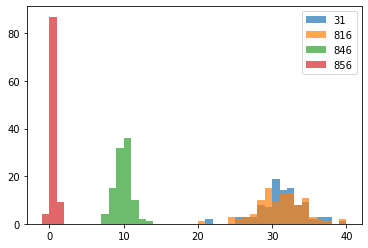

In [223]:
pm, mid = train_model(2000, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

### test

In [244]:
def get_pred(tss, forecasts, idx):
    rec = np.zeros((3))
    rec[0] = list(tss[idx].values)[0]
    
    if isinstance(scaler, str):
        truth = int(rec[0])
    else:
        truth = int(scaler.inverse_transform(rec)[0])
    
    ret = []
    for sample in forecasts[idx].samples:
        rec[0] = sample
        if isinstance(scaler, str):
            ret.append(int(rec[0]))    
        else:
            ret.append(int(scaler.inverse_transform(rec)[0]))    
        
    print('idx:', idx, 't:', truth, 'p:', int(np.mean(ret)))
    plt.hist(ret, bins=range(min(ret),max(ret)+1), alpha=0.7, label='%s'%idx)
    return truth, ret

def run_test(tss, forecasts, testlist):
    for idx in testlist:
        get_pred(tss, forecasts, idx)
    plt.legend()

In [104]:
trec = next(iter(train_ds))
trec


{'target': array([1.46169051]), 'feat': array([-0.64173227, -1.57348481])}

idx: 31 t: 31 p: 30
idx: 816 t: 44 p: 29
idx: 846 t: 14 p: 6
idx: 856 t: 4 p: 0


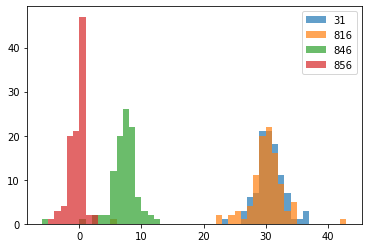

In [197]:
run_test(tss, forecasts, [31,816,846,856])

In [165]:
test_sel.iloc[816]

lap2nextpit      44.0
caution_laps      0.0
pitage            0.0
pit_oncaution     0.0
carno            12.0
eid               5.0
lap              49.0
stint_len        44.0
Name: 1077, dtype: float64

In [171]:
test_sel.iloc[836]

lap2nextpit      24.0
caution_laps     12.0
pitage           20.0
pit_oncaution     0.0
carno            12.0
eid               5.0
lap              69.0
stint_len        44.0
Name: 1097, dtype: float64

In [235]:
t[mid],s[mid] = eval_model(pm)

Running evaluation: 100%|██████████| 3638/3638 [00:17<00:00, 205.30it/s]

{
    "MSE": 0.6918114296565665,
    "abs_error": 2726.1717866286026,
    "abs_target_sum": 3677.5622829723397,
    "abs_target_mean": 1.0108747341870092,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.6370308383276133,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2926.728351150853,
    "Coverage[0.1]": 0.44887300714678396,
    "QuantileLoss[0.5]": 2726.1717866286026,
    "Coverage[0.5]": 0.5104452996151732,
    "QuantileLoss[0.9]": 1433.9767268862302,
    "Coverage[0.9]": 0.7344694887300715,
    "RMSE": 0.8317520241373426,
    "NRMSE": 0.8228042466668978,
    "ND": 0.7412986040375668,
    "wQuantileLoss[0.1]": 0.7958337958549446,
    "wQuantileLoss[0.5]": 0.7412986040375668,
    "wQuantileLoss[0.9]": 0.38992588474320494,
    "mean_wQuantileLoss": 0.6423527615452388,
    "MAE_Coverage": 0.17494960601062856
}


idx: 816 t: 426 p: 16


(426,
 [16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16])

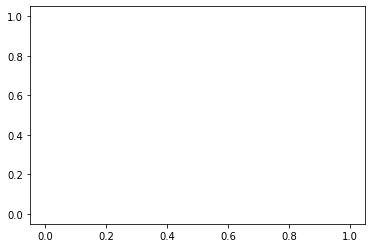

In [252]:
get_pred(t[mid],s[mid], 816)

In [251]:
next(iter(test_ds))

{'target': array([31.]),
 'feat': array([0., 1.]),
 'start': Timestamp('2019-01-01 00:00:00', freq='T'),
 'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')}

In [253]:
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)